In [739]:
library(repr)
options(repr.plot.width=14, repr.plot.height=7, repr.plot.res = 150)

In [2]:
library(tidyverse)
library(data.table)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




In [3]:
setwd("/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/")

# de-novo db

de-novo db description: 
> denovo-db (current release v.1.6.1) is a collection of germline de novo variants identified in the human genome. de novo variants are those present in children but not their parents (see figure to right).
With the advancements in whole-exome and whole-genome sequencing we are now able to assess 1000s of these variants. To provide a landing place for de novo variation we created denovo-db, which has been assembled using the published literature.

>Many large exome and genome studies have focused on neurodevelopmental disorders and while we are very interested in these disorders we have not limited our database to only these phenotypes.
The information types present in denovo-db have been refined to include what we think is highly relevant for genetic studies (for example basic functional annotation, CADD scores, and validation status).
Our goal is to provide a compendium of all de novo variants to benefit the larger researcher community and to allow researchers to ask various scientific questions such as:
> 1. Which sites in the human genome have de novo mutations?
> 2. Which sites are highly mutable to de novo mutation?
> 3. What are features of de novo variants generally and in disease?
> 4. What kinds of phenotypes are represented by de novo variants?

[link to de-novo db](http://denovo-db.gs.washington.edu/denovo-db/Download.jsp)



In [4]:
dir("./external_db/denovo-db/", '*tsv')

[1] "denovo-db.non-ssc-samples.variants.tsv"
[2] "denovo-db.ssc-samples.variants.tsv"

In [5]:
nssc <- read_delim("external_db/denovo-db/denovo-db.non-ssc-samples.variants.tsv", 
                   skip = 1, delim = "\t")
ssc <- read_delim("external_db/denovo-db/denovo-db.ssc-samples.variants.tsv", 
                   skip = 1, delim = "\t")

Parsed with column specification:
cols(
  .default = col_double(),
  `#SampleID` = col_character(),
  StudyName = col_character(),
  SequenceType = col_character(),
  PrimaryPhenotype = col_character(),
  Validation = col_character(),
  Variant = col_character(),
  AncestralAllele = col_character(),
  Transcript = col_character(),
  Gene = col_character(),
  FunctionClass = col_character(),
  cDnaVariant = col_character(),
  ProteinVariant = col_character(),
  `Exon/Intron` = col_character()
)

See spec(...) for full column specifications.

Warning message:
“11075 parsing failures.
   row col expected actual                                                           file
404441 Chr a double      X 'external_db/denovo-db/denovo-db.non-ssc-samples.variants.tsv'
404442 Chr a double      X 'external_db/denovo-db/denovo-db.non-ssc-samples.variants.tsv'
404443 Chr a double      X 'external_db/denovo-db/denovo-db.non-ssc-samples.variants.tsv'
404444 Chr a double      X 'external_db/denovo-db/d

In [6]:
hits <- read_csv("Hitlist_20191230.csv") %>% pull(hgnc_symbol)
tfs <- read_csv("TFlist_20191230.csv") %>% pull(hgnc_symbol)
genes <- read_table2("atac/Protein_coding_genes_Up_2k_20191230.bed", col_names = F) %>% pull(X5) %>% unique

Parsed with column specification:
cols(
  gene_name = col_character(),
  hgnc_symbol = col_character()
)

Parsed with column specification:
cols(
  gene_name = col_character(),
  hgnc_symbol = col_character()
)

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_character(),
  X6 = col_character()
)



In [7]:
names(nssc) <- str_replace(names(nssc), "#", "")
names(ssc) <- str_replace(names(nssc), "#", "")

In [781]:
nssc %>% dim
ssc %>% dim

[1] 415515     31

[1] 212719     31

In [14]:
# disease phynotypes and selected mutation types
disease.list <- c('autism', 'developmentalDisorder', 'intellectualDisability','schizophrenia','tourette_syndrome',
                  'cerebral_palsy','epilepsy','bipolar_type2','amyotrophic_lateral_sclerosis', 'neural_tube_defects','bipolar_type1','early_onset_parkinson',
                  'early_onset_alzheimer','cantu_syndrome','sporadic_infantile_spasm_syndrome', 'acromelic_frontonasal_dysostosis')

mutation.list <- c('frameshift','stop-gained','codingComplex','missense')

In [795]:
# create gene sets for each disease and mutation type
denovo.db.sets.both = map_dfr(list(nssc, ssc), ~ filter(.x, PrimaryPhenotype %in% disease.list & FunctionClass %in% mutation.list & Gene %in% genes)) %>% 
                                            select(PrimaryPhenotype, FunctionClass, Gene) %>% unique %>% 
                                            arrange(PrimaryPhenotype, FunctionClass, Gene) %>% 
                                            group_by(PrimaryPhenotype, FunctionClass) %>% nest                                       

In [816]:
# create gene sets for each disease, mutation type can be any within mutation.list
denovo.db.sets.disease = map_dfr(list(nssc, ssc), ~ filter(.x, PrimaryPhenotype %in% disease.list & FunctionClass %in% mutation.list & Gene %in% genes)) %>% 
                                            select(PrimaryPhenotype, Gene) %>% unique %>% 
                                            arrange(PrimaryPhenotype, Gene) %>% 
                                            group_by(PrimaryPhenotype) %>% nest

#### Hypergeometric test on enrichment

In [679]:
hyper_enrich2 <- function(test.set, enrichment.set, pop.set) {
    # population: all black & white balls; all genes
    # m: all white balls; all hit genes
    # n: all black balls; all non-hit genes
    # q: number of white balls drawn; number of hit genes found in a particular disease set
    # k: number of balls drawn; number of genes in a particular disease set
    
    q = intersect(test.set, enrichment.set) %>% length # hit genes that are also in disease set genes
    m = length(unique(enrichment.set)) # all hit genes
    n = length(unique(pop.set)) - m # all non-hit genes
    k = length(unique(test.set)) # all genes in disease set
    
    return(phyper(q = q - 1, m = m, n = n, k = k, lower.tail = F))
}

# enrichment on disease set on all TF

In [855]:
# enrichment of all(any) TFs in the population of all genes
non_hit_tf <- setdiff(tfs, hits)
denovo.db.disease.tf.enrichment  = mutate(denovo.db.sets.disease, p = map_dbl(data, ~ hyper_enrich2(test.set = flatten(.x), enrichment.set = non_hit_tf, genes)),
       n_enrich = map(data, ~ intersect(tfs, unlist(flatten(.x)))) %>% 
               flatten %>% length,
       enriched.genes = map(data, ~ intersect(tfs, unlist(flatten(.x))))) %>%
    select(-enriched.genes, -data) %>%
    arrange(p)

In [856]:
denovo.db.disease.tf.enrichment

PrimaryPhenotype,p,n_enrich
<chr>,<dbl>,<int>
developmentalDisorder,1.158155e-16,484
autism,9.867012e-13,488
intellectualDisability,2.677679e-09,126
epilepsy,4.081775e-03,39
amyotrophic_lateral_sclerosis,5.409231e-03,17
schizophrenia,1.962341e-02,64
tourette_syndrome,7.134445e-02,35
bipolar_type2,1.421048e-01,3
bipolar_type1,1.638274e-01,5


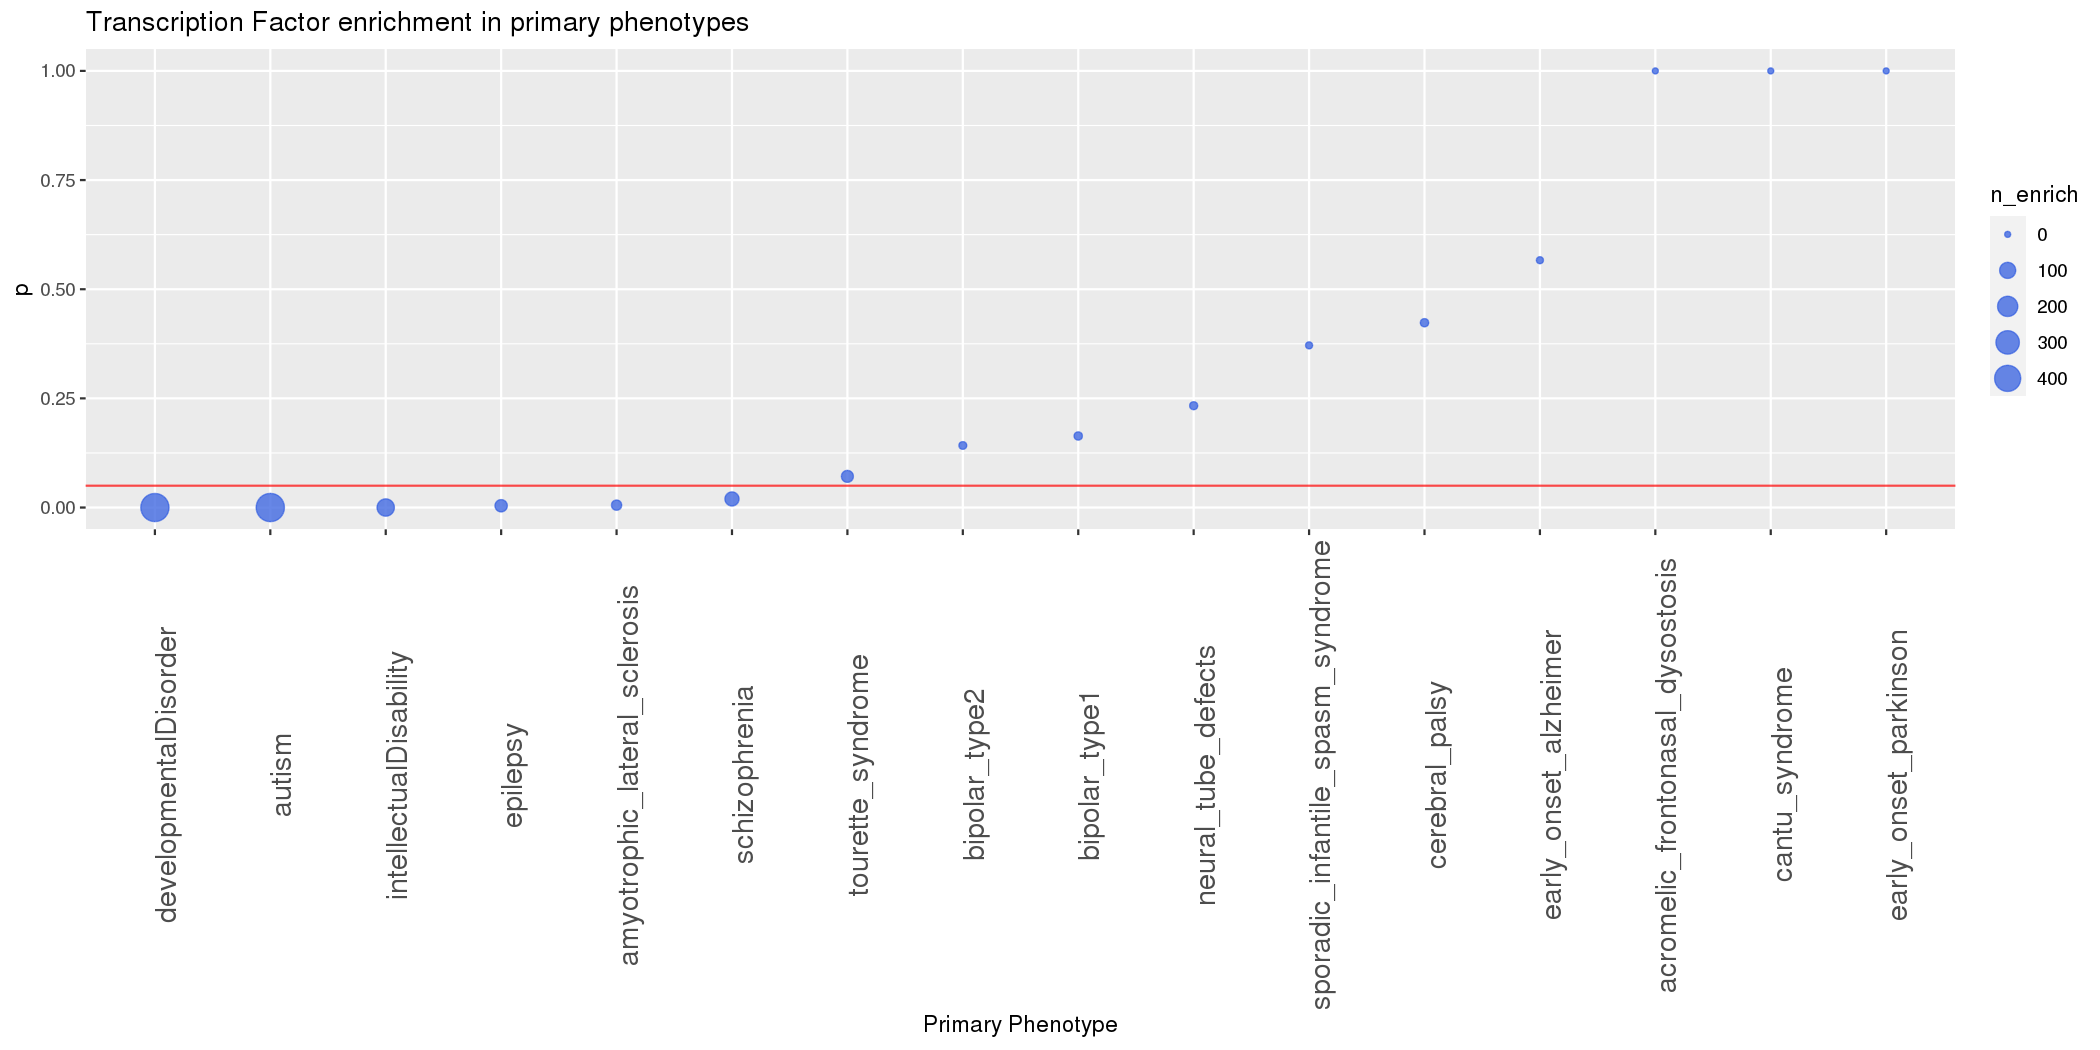

In [859]:
ggplot(denovo.db.disease.tf.enrichment) + 
    geom_point(aes(fct_reorder(PrimaryPhenotype, p), p, size = n_enrich),
               color = 'royalblue', alpha = .8) +
    geom_hline(yintercept = .05, color = 'red', alpha = .7) +
    labs(x = 'Primary Phenotype', title = 'Transcription Factor enrichment in primary phenotypes') +
    theme(axis.text.x = element_text(angle = 90, size = 14))

#### Enrichment of both disease and mutation on TF

In [861]:
denovo.db.sets.both[1:2, ]

PrimaryPhenotype,FunctionClass,data
<chr>,<chr>,<list>
acromelic_frontonasal_dysostosis,missense,ZSWIM6
amyotrophic_lateral_sclerosis,frameshift,"CSNK1G3, SRCAP"


In [862]:
denovo.db.sets.both.tf.enrichment  = mutate(denovo.db.sets.both, p = map_dbl(data, ~ hyper_enrich2(test.set = flatten(.x), enrichment.set = non_hit_tf, genes)),
       n_enrich = map(data, ~ intersect(tfs, unlist(flatten(.x)))) %>% 
               flatten %>% length,
       enriched.genes = map(data, ~ intersect(tfs, unlist(flatten(.x))))) %>%
    select(-enriched.genes, -data) %>%
    arrange(p)

Warning message:
“Removed 1 rows containing missing values (geom_point).”


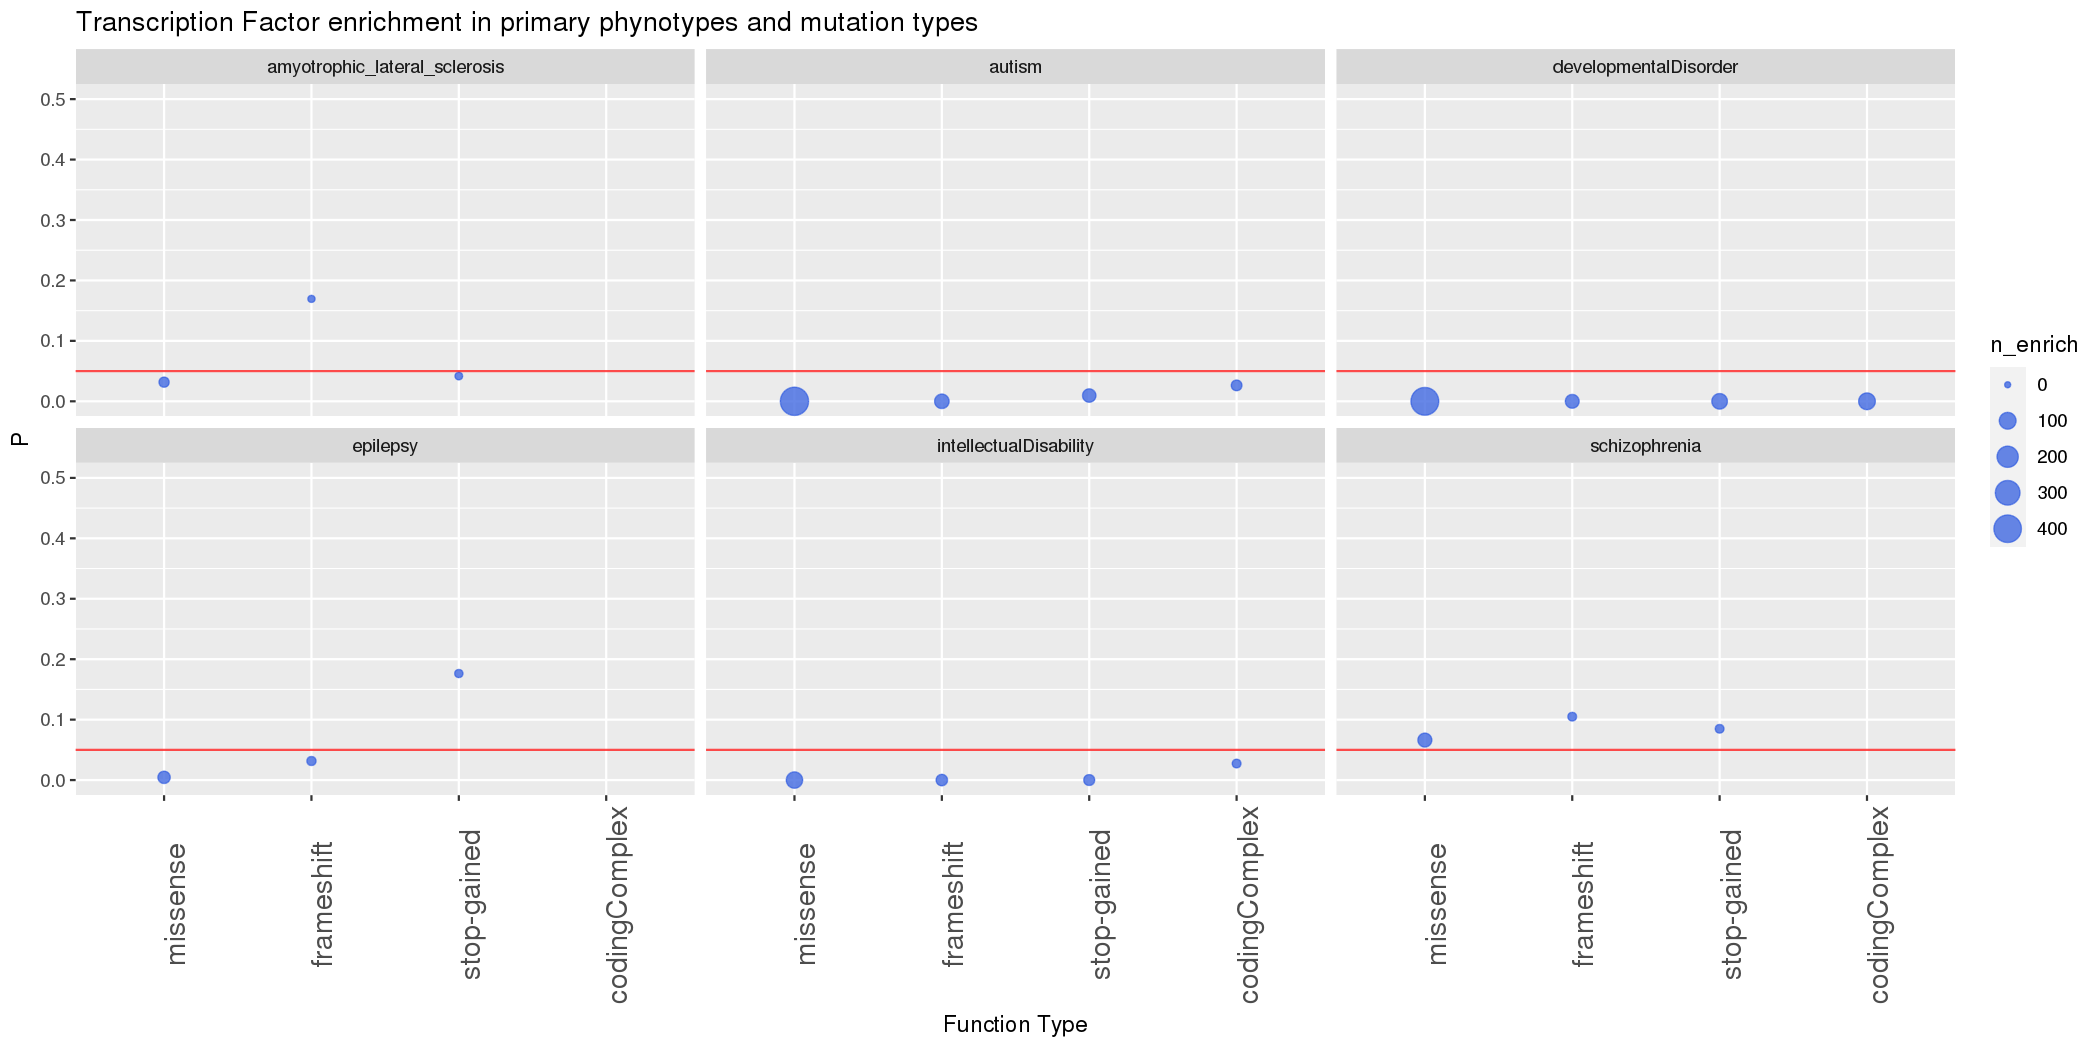

In [894]:
denovo.db.sets.both.tf.enrichment %>% 
    filter(PrimaryPhenotype %in% c('autism', 'developmentalDisorder', 'intellectualDisability', 'epilepsy',
                                  'amyotrophic_lateral_sclerosis', 'schizophrenia')) %>%
    ggplot() + geom_point(aes(fct_reorder(FunctionClass, p), p, size = n_enrich),
               color = 'royalblue', alpha = .8) +
    geom_hline(yintercept = .05, color = 'red', alpha = .7) +
    ylim(c(0, .5)) +
    labs(x = 'Function Type', y = 'P', title = 'Transcription Factor enrichment in primary phynotypes and mutation types') +
    theme(axis.text.x = element_text(angle = 90, size = 14)) +
    facet_wrap(~PrimaryPhenotype)

### Enrichment on Hits

In [871]:
denovo.db.sets.disease[1:2, ]

PrimaryPhenotype,data
<chr>,<list>
acromelic_frontonasal_dysostosis,ZSWIM6
amyotrophic_lateral_sclerosis,"ABL2 , ADAM33 , AK9 , ANAPC7 , ARHGEF18, ASCC3 , BAHCC1 , C10orf90, C6orf89 , C8B , CAB39 , CACNA1B , CEL , CEP70 , CHRM1 , CLCN2 , CNOT1 , COG5 , COL15A1 , CSNK1G3 , EHMT1 , ELL , EPHA2 , FBXL13 , FBXW8 , FOXK1 , FOXN3 , GPR132 , GTF2H4 , HDAC10 , HS3ST2 , HYAL4 , ITPR2 , KIF13A , KMT2C , LIMD1 , LRIG2 , LTBP4 , LTV1 , MAP3K6 , METTL22 , MFSD12 , MKI67 , NPTXR , NTM , OAS3 , OR2T11 , PACS1 , PAPPA , PCK1 , PDCD1 , PIK3C2B , PKD1 , PLA2G4C , PLD1 , PLEKHO2 , PROS1 , PSMB7 , PTCRA , PTPN1 , PXDNL , RBM33 , RINL , RP1L1 , RRP1B , RTEL1 , SARDH , SH2D3A , SHD , SLC6A17 , SLC9A5 , SND1 , SNRNP200, SRCAP , SREBF1 , SRP72 , SS18L1 , STARD13 , STK36 , SV2A , SYT15 , TECTA , TENM3 , TJP3 , TLE2 , TRPM4 , TRRAP , UTP6 , VCL , VPS11 , WDR1 , ZFP64 , ZNF292 , ZNF410 , ZNF618 , ZNF778 , ZNF793 , ZWILCH"


In [872]:
denovo.db.disease.enrichment =  mutate(denovo.db.sets.disease, 
                               p = map_dbl(data, ~ hyper_enrich2(test.set = flatten(.x), enrichment.set = hits, genes)), 
                               n_enriched = map(data, ~ intersect(hits, unlist(flatten(.x)))) %>% flatten %>% length,
                               enriched.genes = map(data, ~ intersect(hits, unlist(flatten(.x))))
                               ) %>% select(-data)

In [875]:
denovo.db.disease.enrichment[, 1:3] %>% filter(n_enriched > 0)

PrimaryPhenotype,p,n_enriched
<chr>,<dbl>,<int>
autism,0.03632282,32
developmentalDisorder,0.11283078,28
epilepsy,0.20869450,3
intellectualDisability,0.20257320,7
schizophrenia,0.63097642,3
tourette_syndrome,0.83978380,1


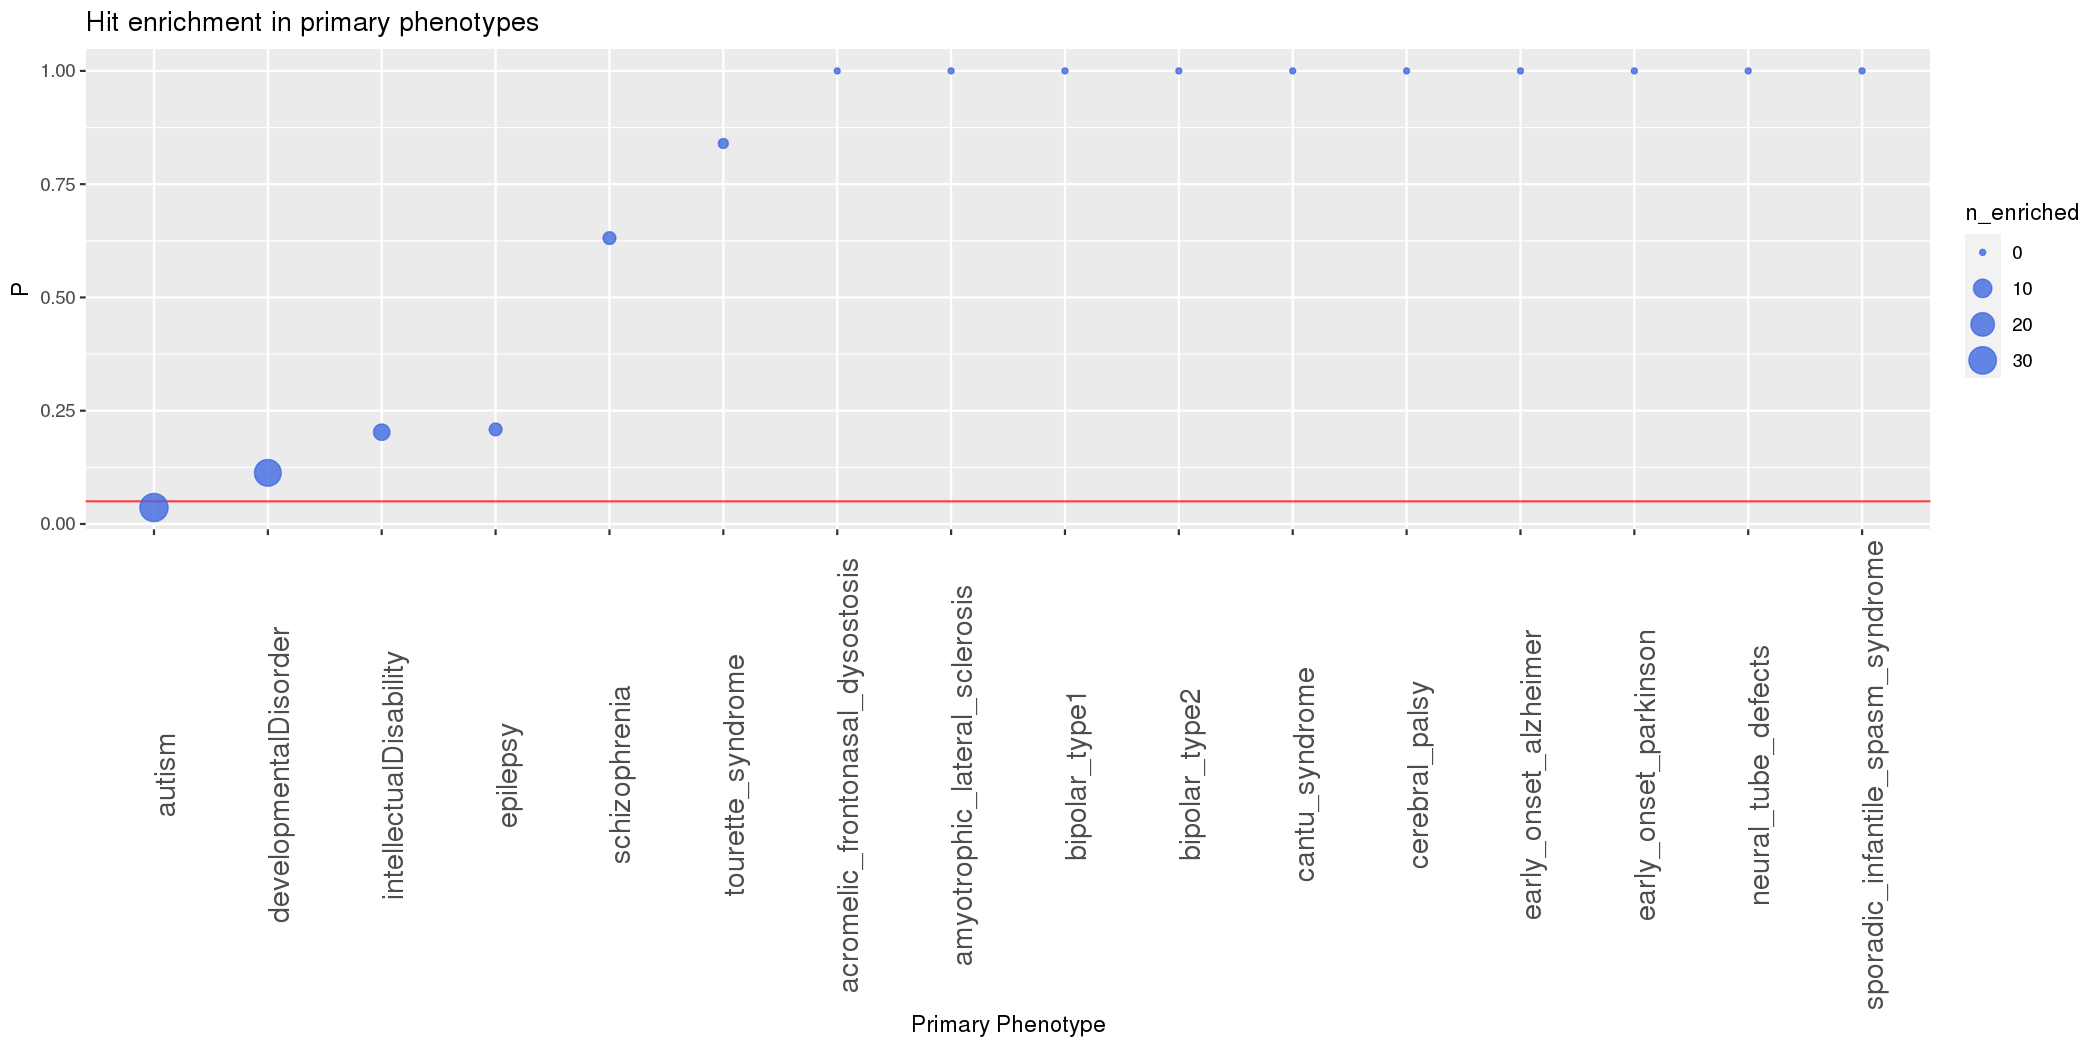

In [876]:
denovo.db.disease.enrichment[,1:3] %>%
    ggplot() + geom_hline(yintercept = .05, color = 'red', alpha = .7) +
                geom_point(aes(fct_reorder(PrimaryPhenotype, p), p, size = n_enriched), 
                          color = 'royalblue', alpha = .8) +
                labs(x = 'Primary Phenotype', title = 'Hit enrichment in primary phenotypes', y = 'P') +
                theme(axis.text.x = element_text(angle = 90, size = 14))

These hit genes are enriched in disease

In [854]:
denovo.db.disease.enrichment %>% filter(p < .05)

PrimaryPhenotype,p,n_enriched,enriched.genes
<chr>,<dbl>,<int>,<list>
autism,0.03632282,32,"TAF1L , TFEB , ISL2 , ZNF563 , RCOR2 , TAF5 , RAI14 , PHF12 , BRWD1 , ZNF311 , EGR3 , ASB1 , CBX4 , ARID1B , CNOT6 , EBF1 , AHR , ZNF250 , SKI , ARNTL , RORB , ZNF441 , MPHOSPH8, ZFPM1 , CTDP1 , MECP2 , PAX2 , ZFP2 , CHD5 , CTNNB1 , HTATIP2 , NEUROG3"


These genes are enriched in disease and mutation types

In [877]:
denovo.db.sets.both.enrichment =  mutate(denovo.db.sets.both, 
                               p = map_dbl(data, ~ hyper_enrich2(test.set = flatten(.x), enrichment.set = hits, genes)), 
                               n_enriched = map(data, ~ intersect(hits, unlist(flatten(.x)))) %>% flatten %>% length,
                               enriched.genes = map(data, ~ intersect(hits, unlist(flatten(.x))))
                               ) %>% select(-data)

In [886]:
denovo.db.sets.both.enrichment %>% filter(p < .05) %>% arrange(p)

PrimaryPhenotype,FunctionClass,p,n_enriched,enriched.genes
<chr>,<chr>,<dbl>,<int>,<list>
autism,stop-gained,0.0005134961,8,"CBX4 , ARID1B , EBF1 , SKI , MPHOSPH8, MECP2 , ZFP2 , CTNNB1"
developmentalDisorder,stop-gained,0.0047759545,6,"BRWD1 , EMX1 , ARID1B, MECP2 , ZBTB18, CTNNB1"
developmentalDisorder,codingComplex,0.0075669388,7,"NFAT5 , PHF12 , ARID1B, TSHZ3 , PAX2 , ZBTB18, CTNNB1"
intellectualDisability,stop-gained,0.0080648097,3,"PHF12 , ARID1B, CTNNB1"
intellectualDisability,frameshift,0.0189412546,3,"ARID1B, MECP2 , CTNNB1"
autism,frameshift,0.0401383313,5,"PHF12 , BRWD1 , ARID1B, MECP2 , PAX2"


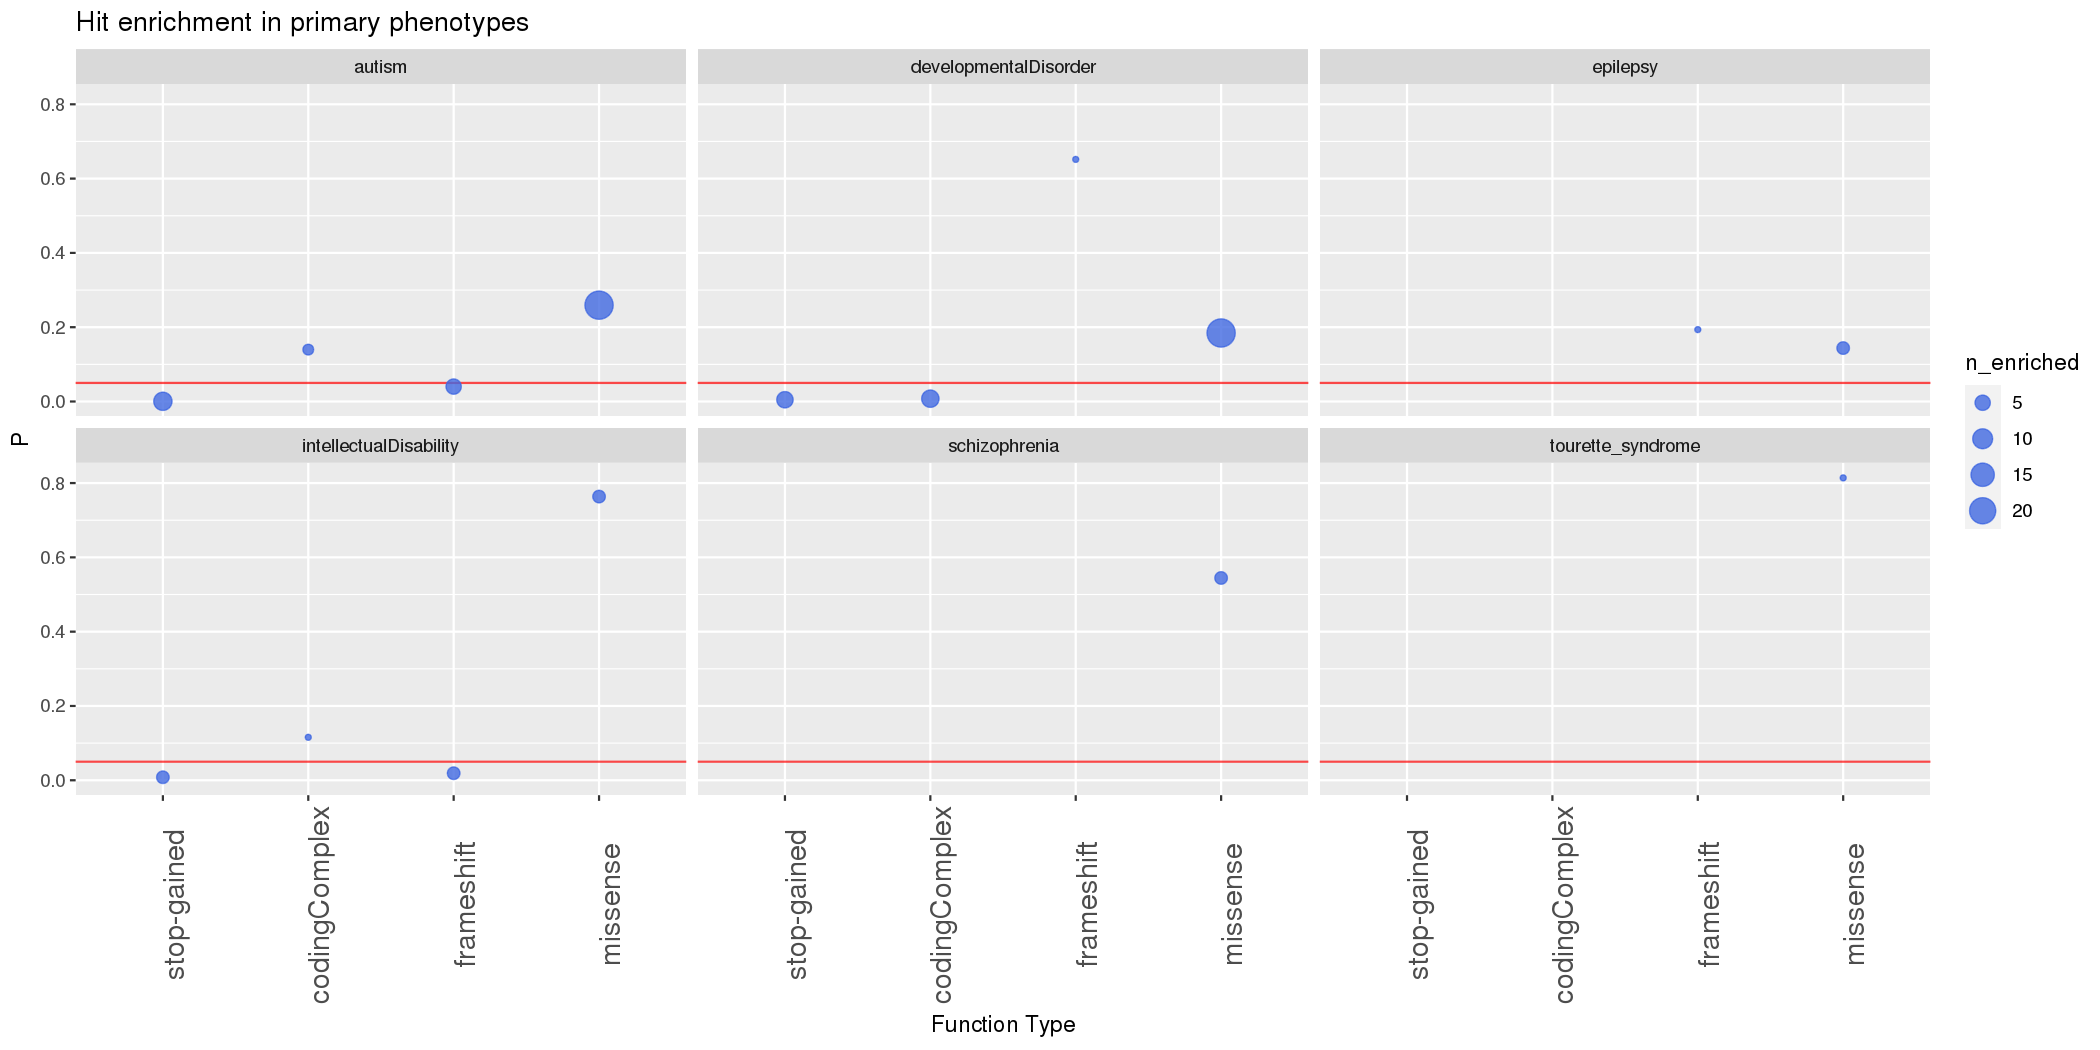

In [896]:
denovo.db.sets.both.enrichment[,1:4] %>% filter(p < 1) %>%
    ggplot() + geom_hline(yintercept = .05, color = 'red', alpha = .7) +
                geom_point(aes(fct_reorder(FunctionClass, p), p, size = n_enriched), 
                          color = 'royalblue', alpha = .8) +
                labs(x = 'Function Type', title = 'Hit enrichment in primary phenotypes', y = 'P') +
                theme(axis.text.x = element_text(angle = 90, size = 14)) +
                facet_wrap(~PrimaryPhenotype)

---

# Allen Brain Span - Atlas of the Developing Human Brain: RNA-seq

data downloaded from http://www.brainspan.org/static/download.html
click: RNA-Seq Gencode v10 summarized to genes


In [29]:
dir("./Allen-BrainSpan/brain-dev")

[1] "columns_metadata.csv"  "expression_matrix"     "expression_matrix.csv"
[4] "readme.txt"            "rows_metadata.csv"

In [30]:
column_meta = read_csv('Allen-BrainSpan/brain-dev/columns_metadata.csv')
row_meta = read_csv('Allen-BrainSpan/brain-dev/rows_metadata.csv')

Parsed with column specification:
cols(
  column_num = col_double(),
  donor_id = col_double(),
  donor_name = col_character(),
  age = col_character(),
  gender = col_character(),
  structure_id = col_double(),
  structure_acronym = col_character(),
  structure_name = col_character()
)

Parsed with column specification:
cols(
  row_num = col_double(),
  gene_id = col_double(),
  ensembl_gene_id = col_character(),
  gene_symbol = col_character(),
  entrez_id = col_double()
)



In [31]:
column_meta <- mutate_at(column_meta, "column_num", ~ paste0('S', .x))

In [32]:
expression_matrix_cols <- c('rowNum', paste0('S', seq(1,dim(column_meta)[1])))

In [33]:
expression_matrix <- read_csv('Allen-BrainSpan/brain-dev/expression_matrix.csv', 
                              col_names = c('rowNum', column_meta$column_num))

Parsed with column specification:
cols(
  .default = col_double()
)

See spec(...) for full column specifications.



In [909]:
column_meta %>% head

column_num,donor_id,donor_name,age,gender,structure_id,structure_acronym,structure_name
<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
S1,13058,H376.IIA.51,8 pcw,M,10268,Ocx,occipital neocortex
S2,13058,H376.IIA.51,8 pcw,M,10291,M1C-S1C,primary motor-sensory cortex (samples)
S3,13058,H376.IIA.51,8 pcw,M,10361,AMY,amygdaloid complex
S4,13058,H376.IIA.51,8 pcw,M,10550,MGE,medial ganglionic eminence
S5,13058,H376.IIA.51,8 pcw,M,10243,STC,posterior (caudal) superior temporal cortex (area 22c)
S6,13058,H376.IIA.51,8 pcw,M,10665,URL,upper (rostral) rhombic lip


## Plot ZBTB18 (ZNF238)

In [34]:
zb18.rownum <- filter(row_meta, gene_symbol == 'ZNF238') %>% pull(row_num)

In [918]:
head(expression_matrix,2)

rowNum,S1,S2,S3,S4,S5,S6,S7,S8,S9,⋯,S515,S516,S517,S518,S519,S520,S521,S522,S523,S524
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,36.447128,24.251253,19.33048,27.668607,19.998231,14.68067,27.5481,16.58018,44.587799,⋯,2.320932,1.781548,2.277359,1.832737,1.555696,2.081944,3.484685,4.816781,3.034464,3.082820
2,0.044081,0.067338,0.00000,0.145466,0.185188,0.31118,0.0000,0.00000,0.473831,⋯,0.758571,0.000000,0.061869,0.026876,0.100691,0.140675,0.300576,0.126526,0.000000,0.424134


In [920]:
column_meta %>% head(2)

column_num,donor_id,donor_name,age,gender,structure_id,structure_acronym,structure_name
<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
S1,13058,H376.IIA.51,8 pcw,M,10268,Ocx,occipital neocortex
S2,13058,H376.IIA.51,8 pcw,M,10291,M1C-S1C,primary motor-sensory cortex (samples)


In [921]:
row_meta %>% head(2)

row_num,gene_id,ensembl_gene_id,gene_symbol,entrez_id
<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,7062,ENSG00000000003,TSPAN6,7105
2,40735,ENSG00000000005,TNMD,64102


In [37]:
age.level <- factor(paste(1:100, rep(c('pcw', 'mos', 'yrs'), each = 100)), levels = paste(1:100, rep(c('pcw', 'mos', 'yrs'), each = 100)))

In [960]:
zb18.expression <- expression_matrix[zb18.rownum, -1] %>% 
                    t %>% as.data.frame %>%
                    rownames_to_column('sample') %>% 
                    left_join(column_meta, by = c('sample' = 'column_num')) %>%
                    select(V1, age, structure_acronym, structure_name) %>% # get column information
                    mutate_at("age", ~ factor(age, levels = age.level)) %>%
                    group_by(structure_acronym, structure_name, age) %>% # combine multiple samples at the same time point and same tissue structure
                    summarize(expr = median(V1), n=n()) %>% # summarize by median, and count number of samples %>%
                    arrange(structure_acronym, age)

In [964]:
column_meta$structure_acronym %>% unique

[1] "Ocx"     "M1C-S1C" "AMY"     "MGE"     "STC"     "URL"     "CGE"    
 [8] "DTH"     "MFC"     "DFC"     "OFC"     "LGE"     "ITC"     "HIP"    
[15] "VFC"     "PCx"     "TCx"     "A1C"     "V1C"     "STR"     "M1C"    
[22] "IPC"     "S1C"     "CB"      "CBC"     "MD"

In [965]:
filter(column_meta, structure_acronym %in% c('DFC', 'S1C', 'CBC', 'STR'))[, c('structure_name', 'structure_acronym')] %>% unique

structure_name,structure_acronym
<chr>,<chr>
dorsolateral prefrontal cortex,DFC
striatum,STR
"primary somatosensory cortex (area S1, areas 3,1,2)",S1C
cerebellar cortex,CBC


In [966]:
head(zb18.expression)

structure_acronym,structure_name,age,expr,n
<chr>,<chr>,<fct>,<dbl>,<int>
A1C,primary auditory cortex (core),12 pcw,445.2764,3
A1C,primary auditory cortex (core),13 pcw,345.8178,3
A1C,primary auditory cortex (core),16 pcw,306.7380,3
A1C,primary auditory cortex (core),17 pcw,371.5381,1
A1C,primary auditory cortex (core),19 pcw,211.7646,1
A1C,primary auditory cortex (core),24 pcw,321.5283,1


In [42]:
p <- zb18.expression %>% ggplot() +
    geom_line(aes(age, expr, group = structure_name, color = structure_acronym)) +
    theme_classic() +
    labs(x = 'age', y = 'RPKM') +
    theme(legend.position = 'bottom', axis.text.x = element_text(angle = 45, vjust = .5))

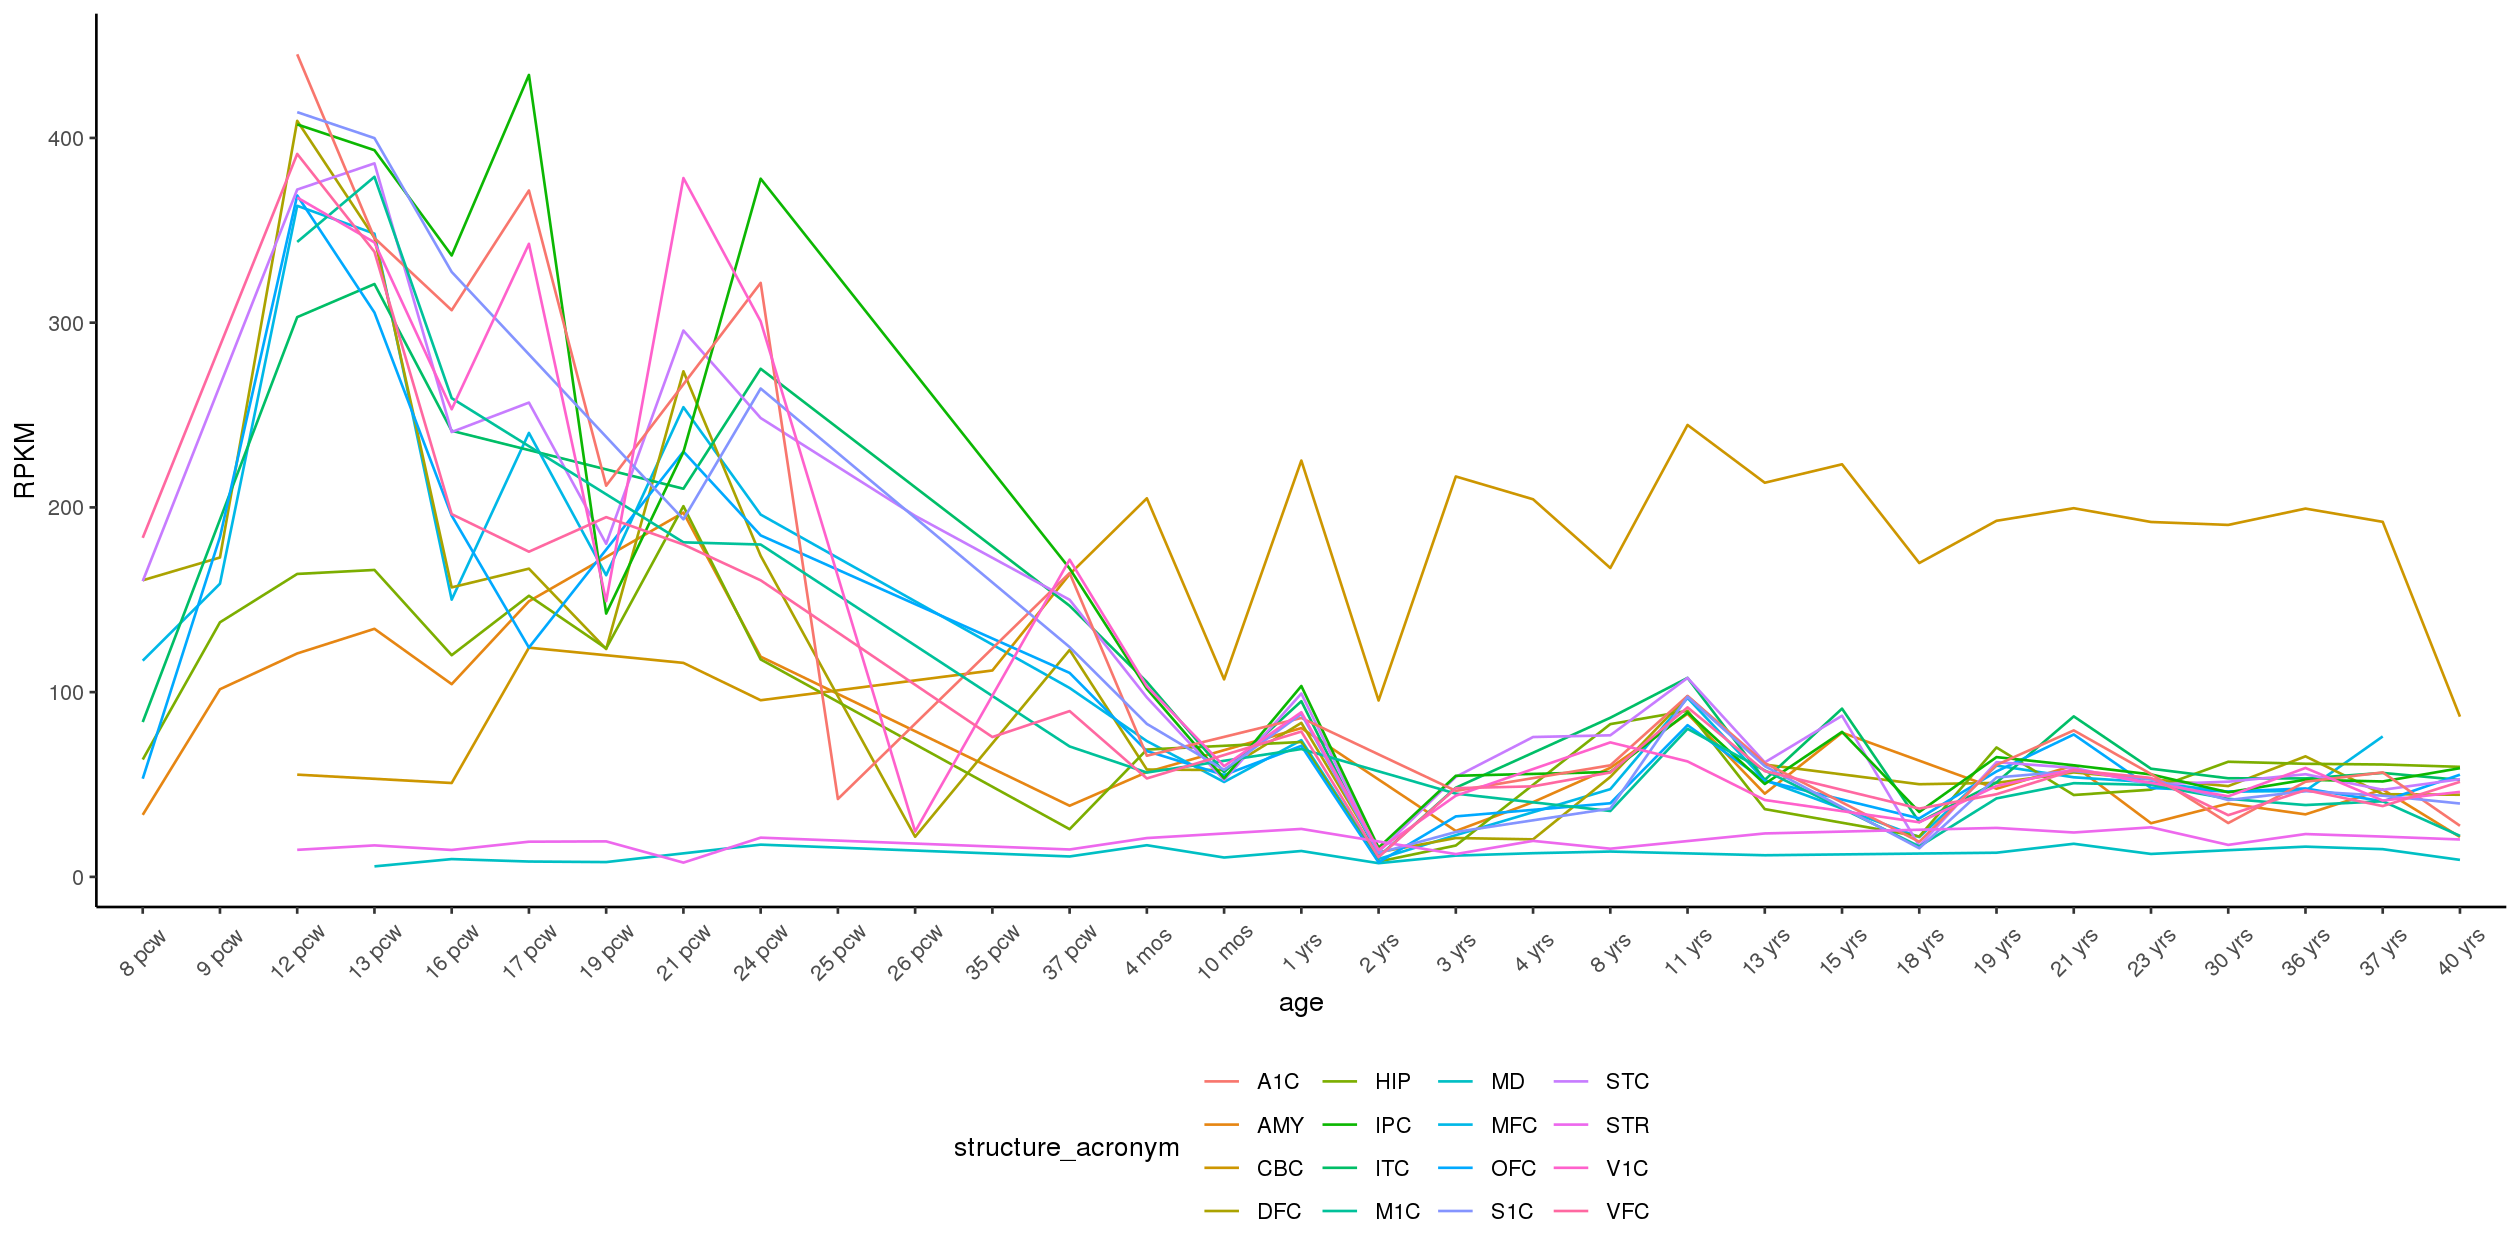

In [43]:
p

## Other interested genes' expressions

Namely: 
`ZBTB18 (ZNF238), FOXN2, POU3F2, VAX2`

In [970]:
gene_set1 = c('ZNF238', 'FOXN2', 'POU3F2', 'VAX2')

In [990]:
gene_set1_row_num = map(gene_set1, ~ filter(row_meta, gene_symbol == .x) %>% pull(row_num))

In [992]:
names(gene_set1_row_num) = gene_set1

In [993]:
gene_set1_row_num

$ZNF238
[1] 14913

$FOXN2
[1] 13062

$POU3F2
[1] 16030

$VAX2
[1] 4563

In [994]:
gene_set1_expr = map(gene_set1_row_num, ~ expression_matrix[.x, -1] %>% 
                     t %>% as.data.frame %>%
                    rownames_to_column('sample') %>% 
                    left_join(column_meta, by = c('sample' = 'column_num')) %>%
                    select(V1, age, structure_acronym, structure_name) %>% # get column information
                    mutate_at("age", ~ factor(age, levels = age.level)) %>%
                    group_by(structure_acronym, structure_name, age) %>% # combine multiple samples at the same time point and same tissue structure
                    summarize(expr = median(V1), n=n()) %>% # summarize by median, and count number of samples %>%
                    arrange(structure_acronym, age)
                    )

In [1006]:
str_replace('ZNF238', 'ZNF238', 'ZBTB18')

[1] "ZBTB18"

In [1010]:
iwalk(gene_set1_expr, ~ str_replace(.y, 'ZNF238', 'ZBTB18') %>%
     paste0('syncClusterCloud/BrainMap_AllStructure_', .,'_expression.csv') %>%
     write_csv(.x, .)
   )

## Plot `dorsolateral prefrontal cortex` and `primary somatosensory cortex`

In [86]:
#filter(column_meta, str_detect(structure_acronym, iwant)) %>% select(7,8) %>% unique

In [87]:
# get sample names of these 4 structures
iwant = c('DFC', 'S1C', 'CBC', 'STR')
cortex.samples = map(iwant, ~ filter(column_meta, structure_acronym == .x) %>% pull(column_num))
names(cortex.samples) = iwant

In [88]:
cortex.samples

$DFC
 [1] "S10"  "S17"  "S39"  "S55"  "S68"  "S88"  "S96"  "S107" "S123" "S142"
[11] "S148" "S164" "S183" "S199" "S202" "S219" "S233" "S248" "S269" "S274"
[21] "S283" "S302" "S331" "S337" "S352" "S365" "S373" "S391" "S411" "S418"
[31] "S435" "S473" "S486" "S500" "S510"

$S1C
 [1] "S45"  "S52"  "S70"  "S79"  "S91"  "S106" "S145" "S196" "S203" "S232"
[11] "S266" "S271" "S289" "S299" "S323" "S342" "S372" "S390" "S412" "S423"
[21] "S442" "S458" "S468" "S490" "S494" "S524"

$CBC
 [1] "S66"  "S138" "S169" "S184" "S197" "S214" "S220" "S228" "S241" "S268"
[11] "S277" "S291" "S304" "S313" "S327" "S339" "S351" "S358" "S376" "S388"
[21] "S399" "S415" "S417" "S441" "S457" "S477" "S489" "S496" "S516"

$STR
 [1] "S37"  "S60"  "S65"  "S76"  "S90"  "S115" "S127" "S140" "S153" "S159"
[11] "S182" "S188" "S205" "S229" "S239" "S258" "S296" "S309" "S335" "S353"
[21] "S397" "S422" "S446" "S461" "S463" "S492" "S506" "S523"

In [92]:
library(tictoc)

In [93]:
tic()
expression.bySample <- map(cortex.samples, ~ expression_matrix[, .x] %>% # expression matrix for each cortex samples
                            add_column(gene_id = row_meta$ensembl_gene_id) %>% # add gene_id as column
                            column_to_rownames('gene_id') %>% # set gene_id as rowname
                            t %>% as.data.frame %>% rownames_to_column('sample') %>% # transpose gene to column, sample to rows
                            left_join(column_meta[, c('column_num', 'age')], by = c('sample' = 'column_num')) %>% # use sample to get age
                            mutate_at('age', ~ factor(.x, levels = age.level)) %>% # make age factor for sorting later
                            select(-sample) %>% group_by(age) %>%  summarise_all(median) %>% # remove sample, combine on age using median
                            column_to_rownames('age') %>% t %>% as.data.frame   # transpose to make gene on rows
    )
toc()

1044.709 sec elapsed


In [104]:
expression.bySample$DFC %>% head

,8 pcw,9 pcw,12 pcw,13 pcw,16 pcw,17 pcw,19 pcw,21 pcw,24 pcw,26 pcw,⋯,8 yrs,11 yrs,13 yrs,18 yrs,19 yrs,21 yrs,30 yrs,36 yrs,37 yrs,40 yrs
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003,44.943915,21.538118,6.913950,8.635878,10.405606,6.947937,6.450161,5.272812,10.046465,6.544657,⋯,4.976566,3.329707,2.134030,5.433384,2.112777,2.552389,2.737511,2.142024,2.229368,3.448635
ENSG00000000005,0.181220,0.025361,0.024831,0.000000,0.025624,0.000000,0.000000,0.020691,0.032083,0.000000,⋯,0.292828,0.093023,0.089210,0.096181,0.113757,0.262877,0.000000,0.064448,0.041612,0.215720
ENSG00000000419,38.157569,14.362518,13.346579,10.936272,14.955870,7.351731,10.765165,9.795354,11.552110,6.551851,⋯,9.428918,9.929917,10.939239,12.609470,7.274059,7.785850,13.392135,11.035273,9.849653,30.048822
ENSG00000000457,3.609830,3.821916,2.809731,2.464164,2.984438,2.574319,2.449230,2.251059,3.107960,1.306514,⋯,1.540685,1.813739,1.963937,1.632941,1.861563,2.295840,2.292734,2.318390,3.171521,1.655831
ENSG00000000460,3.560650,4.220291,1.027928,0.851626,1.336469,1.218525,1.004806,0.943555,1.069416,0.590197,⋯,0.448876,0.556223,0.627384,0.731818,0.558742,0.585146,0.649641,0.637114,1.027014,0.652520
ENSG00000000938,0.260205,0.115094,0.195323,0.121462,0.318183,0.289673,0.178150,0.348394,1.195495,3.232295,⋯,1.220483,0.680433,1.591153,0.692244,1.492096,0.343540,0.953234,0.733767,0.783640,1.446497


In [113]:
dir("Allen-BrainSpan/brain-dev")

[1] "columns_metadata.csv"  "expression_matrix"     "expression_matrix.csv"
[4] "readme.txt"            "rows_metadata.csv"

In [641]:
iwalk(expression.bySample, ~ write.table(.x, paste0("expressionBySample_", .y, '.csv'), quote = F, sep = ','))

In [119]:
library(ComplexHeatmap)
library(circlize)

Loading required package: grid

ComplexHeatmap version 2.0.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.


circlize version 0.4.9
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))




In [117]:
TFlist <- read_csv('ProteinGeneList_20191230.csv') %>% filter(isTF)

Parsed with column specification:
cols(
  gene_id = col_character(),
  gene_name = col_character(),
  isTF = col_logical()
)



In [153]:
rowNums <- which(rownames(expression.bySample$DFC) %in% TFlist$gene_id)

In [155]:
geneAnno <- data.frame(gene_id = rownames(expression.bySample$DFC)[rowNums], stringsAsFactors = F) %>%
                left_join(TFlist[, 1:2], by = 'gene_id')

In [156]:
geneAnno %>% filter(gene_name %in% c("ZBTB18", "NEUROG1", "NEUROG2", "EBF1", "NANOG"))

gene_id,gene_name
<chr>,<chr>
ENSG00000111704,NANOG
ENSG00000164330,EBF1
ENSG00000178403,NEUROG2
ENSG00000179456,ZBTB18
ENSG00000181965,NEUROG1


In [157]:
col_fun2 <- colorRamp2(breaks = c(0, 5, 10, 15, 20, 40, 80, 150), c("#FFFFFF","#FFF2DF", "#FFE7CE", "#FFD9B2", "#FFBA64", "#ff5f29", "#c73a0a", "#4f0b27"))
#scales::show_col(col_fun2(seq(1,200,5)), borders = F)

In [158]:
ht.dpc <- Heatmap(t(as.matrix(expression.bySample$DFC[rowNums,])), show_column_dend = F,border = F, 
               column_labels = geneAnno$gene_name,  
               show_column_names = F, show_row_names = T, 
               cluster_rows = F, cluster_columns = T, 
               column_km = 7, column_km_repeats = 100, column_gap = unit(1, "mm"), # cluster rows using k-means
               column_dend_height = unit(4, "cm"), 
               clustering_distance_columns = "euclidean", clustering_method_columns = "average",
               col = col_fun2,
               heatmap_legend_param = list(title = "RPKM", at = c(0,10,20,40,60,100, 120, 150),legend_height = unit(6, "cm"))
       )

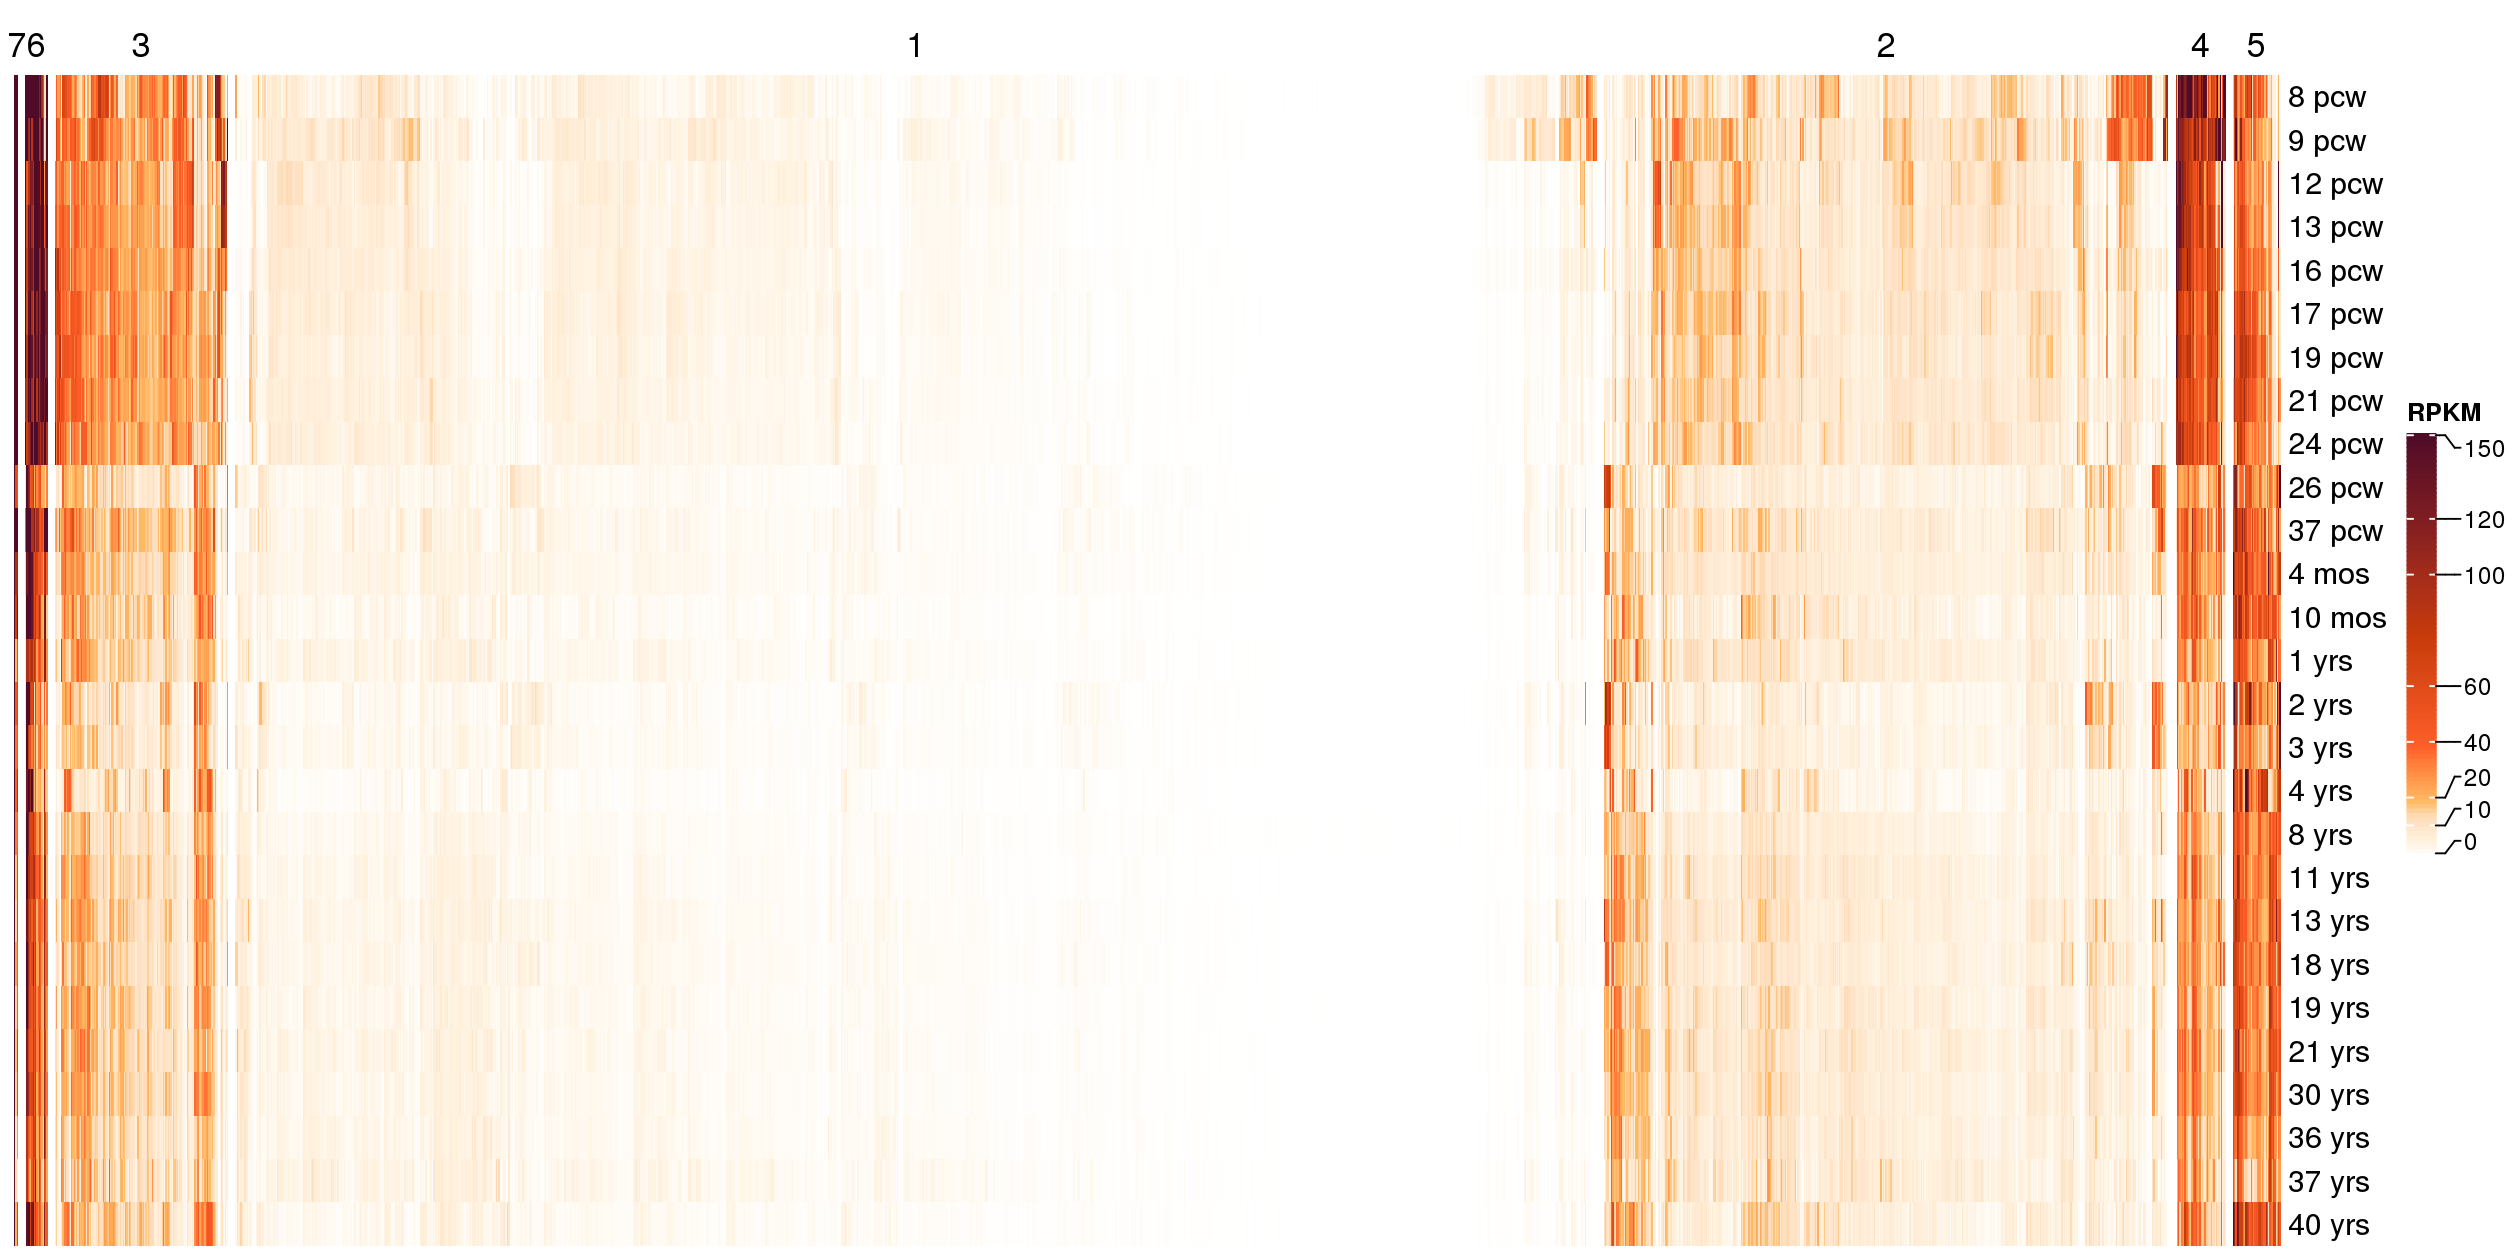

In [159]:
set.seed(123)
draw(ht.dpc)

In [65]:
ht.psc <- Heatmap(t(as.matrix(expression.bySample$PSC[rowNums,])), show_column_dend = F,border = F, 
               column_labels = geneAnno$gene_name,  
               show_column_names = F, show_row_names = T, 
               cluster_rows = F, cluster_columns = T, 
               column_km = 7, column_km_repeats = 100, column_gap = unit(1, "mm"), # cluster rows using k-means
               column_dend_height = unit(4, "cm"), 
               clustering_distance_columns = "euclidean", clustering_method_columns = "average",
               col = col_fun2,
               heatmap_legend_param = list(title = "RPKM", at = c(0,10,20,40,60,100, 120, 150),legend_height = unit(6, "cm"))
       )

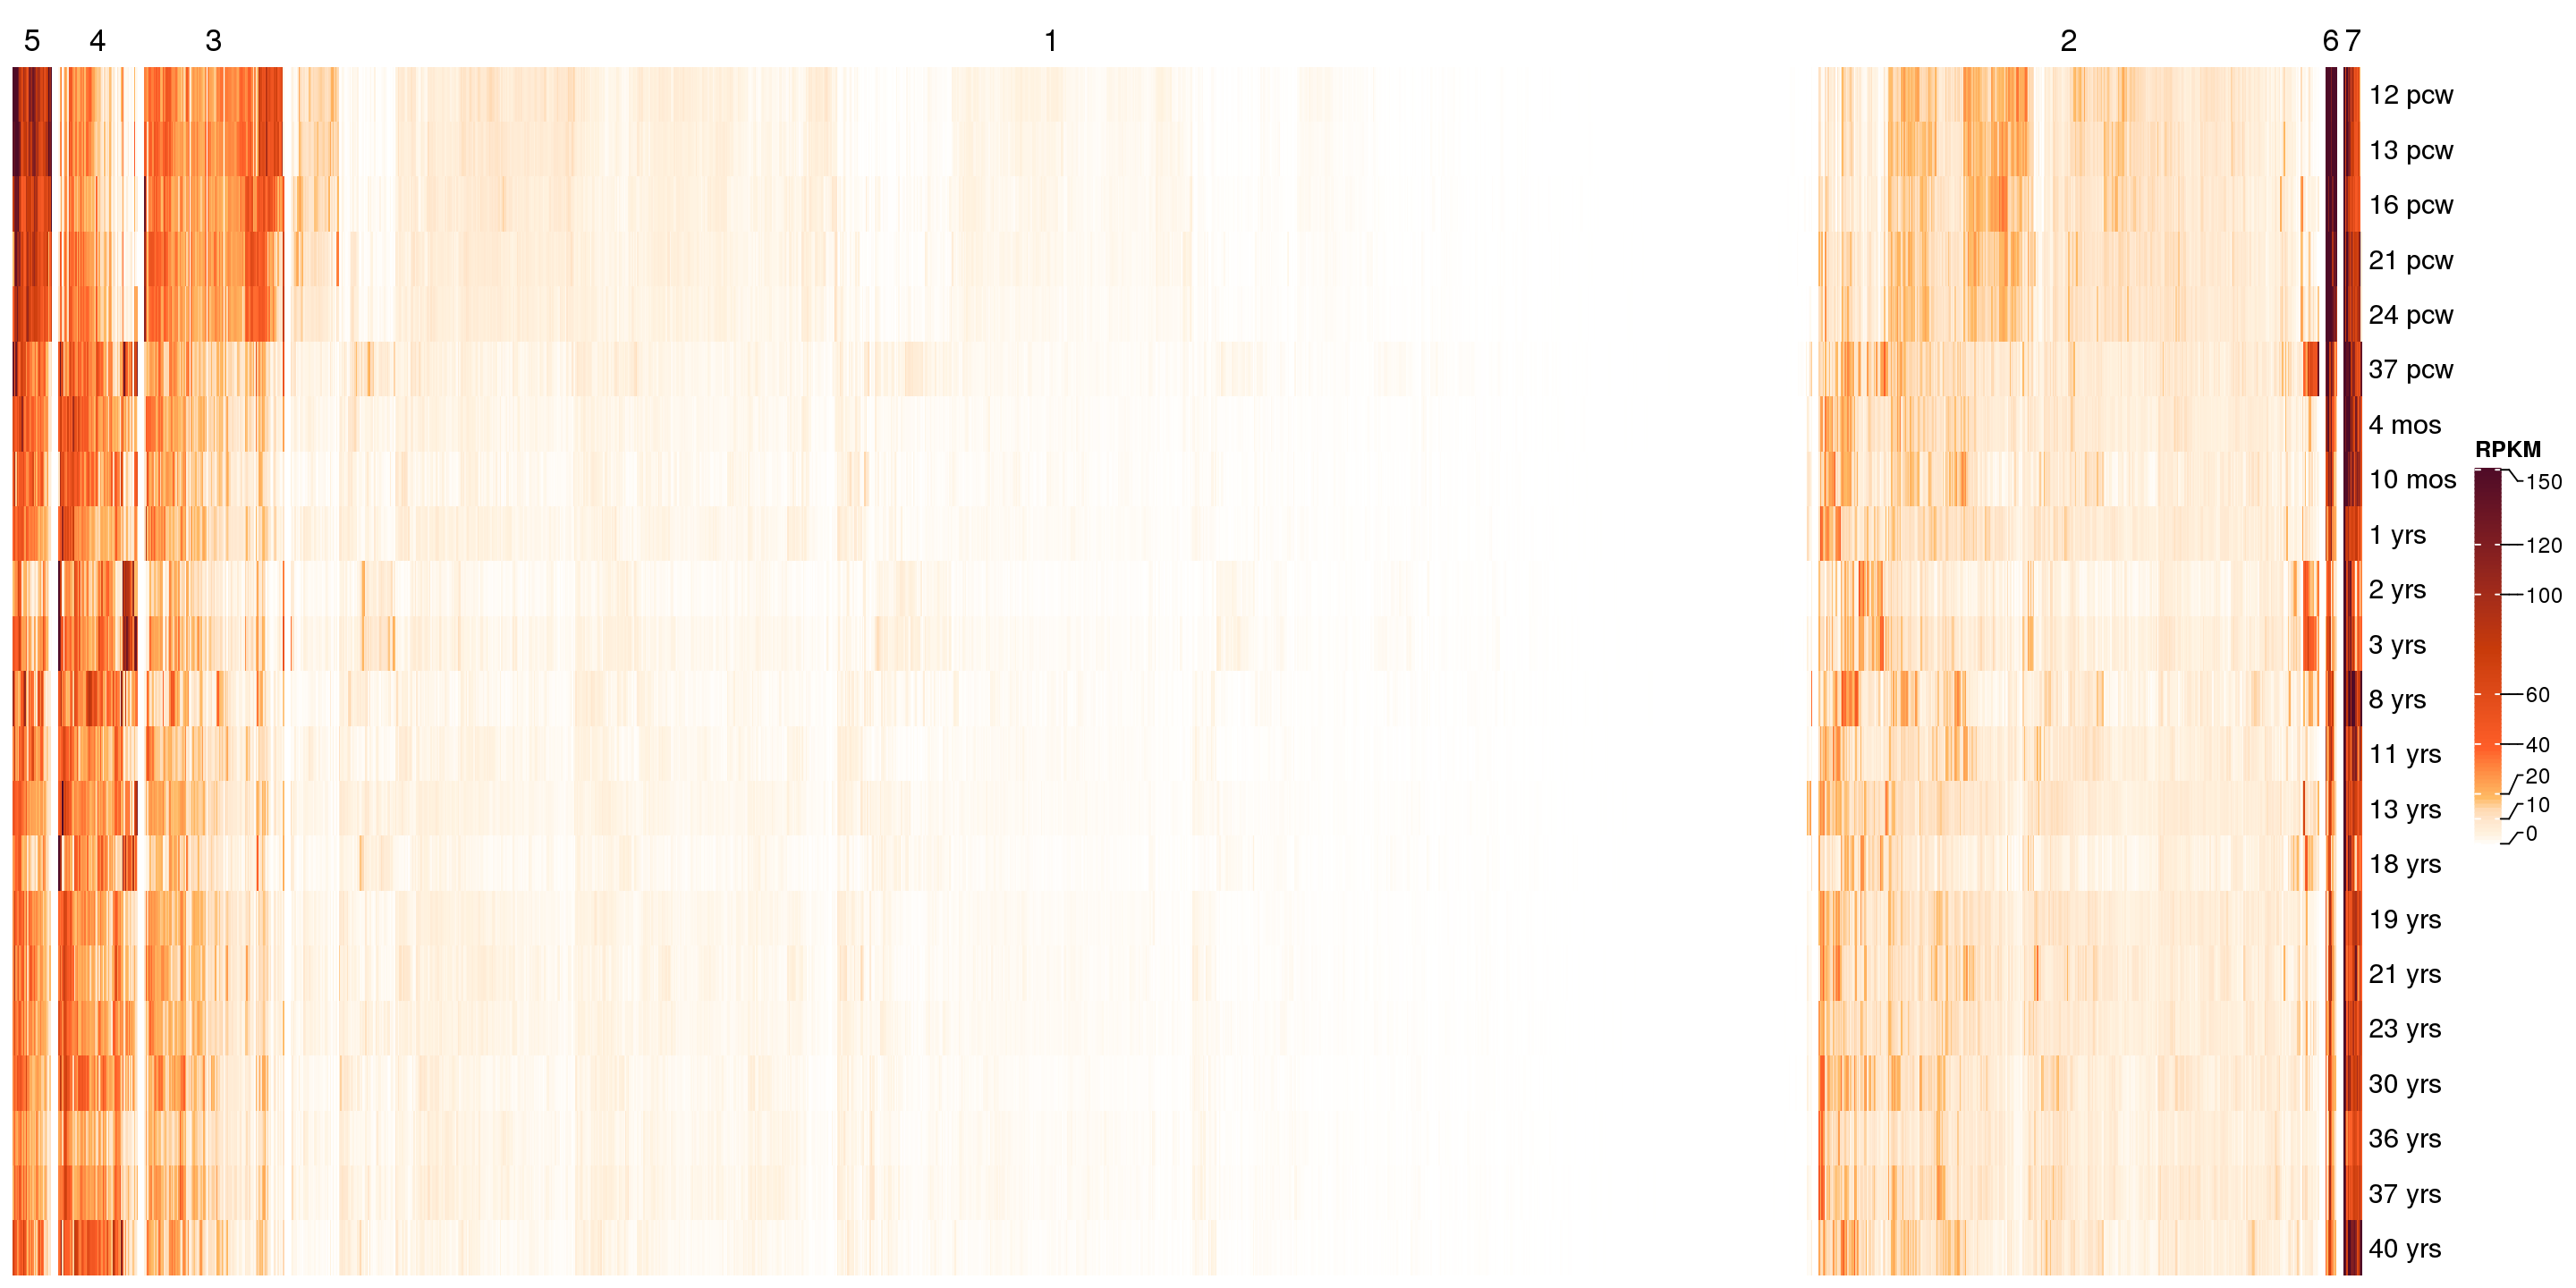

In [66]:
set.seed(123)
ht.psc

In [349]:
tflist <- read.csv('TFlist_20191230.csv', stringsAsFactors = F) %>% pull(hgnc_symbol)

In [401]:
suppressMessages({gene_lookup = read_csv('ProteinCodingGeneID_GeneName_Lookup_20191230.csv') %>%
                      filter(!is.na(gene_name)) %>%
                      mutate(gene_id2 = str_extract(gene_id, 'ENSG[0-9]+'))
                 })

# COMPARE TFSCREEN PROJECT'S CELL RNA-SEQ TF GENE LIST AND BRAIN MAP GENE LIST

- Transcription Factors in cell RNA-seq but not in Brain Map tissue data:

`
'SCRT1''GTF2I''ZNF234''ZNF285''ZNF224''IKBKG''TAF15''KMT2B''ZNHIT3''LHX1''TAF9''ZNF280B''MLLT6''ZNF2''H2BC9''TADA2A''DACH1''PCGF2''ZNF670''ZNF229''MATR3''POLR2J3'
`

- Transcription Factors in Brain Map tissue data but not in cell RNA-seq:

`
MEOX1''ASB4''DLX6''TFAP2B''TFAP2D''NFIX''ETV7''ZBTB32''RUNX3''HOXC8''BARX2''ALX4''CREB3L3''DLX3''DMRT3''STON1-GTF2A1L''PITX1''TP63''PAX2''SP140''PGR''MECOM''TBX5''POU4F3''SEC14L2''VSX1''HNF4A''SLA2''NFATC2''RHOXF1''HSF4''LYL1''TLE6''KLF1''TFEC''HOXA1''HOXA3''HOXA6''HOXA13''EVX1''PAX4''LHX3''PITX3''DLX4''HLF''ZBTB16''POU2AF1''MYF5''VDR''EYA4''NR2E1''TFEB''HAND1''CDX1''KCNIP3''OTX1''SMYD1''DLX2''PRRX1''CHD5''TCF21''VSX2''HOXB8''HOXB1''TBX22''HOXA7''TAF1L''NEUROG3''EGR2''HOXC13''HOXC11''NFE2''SPDEF''RUNX2''GCM2''PAX8''FOSB''NKX2-2''SSX1''PRDM7''KLF2''IRF5''HOXD3''HOXD13''FOXA1''FOXJ1''GATA5''RBBP8NL''NPAS1''BARX1''ZNF132''PPARG''GSC''RAX''SPOCD1''HNF1A''ELF5''EGR4''NKX2-8''TBR1''GATA4''DMRT1''TFAP2A''GCM1''TRIM29''POU2F3''BRDT''FOXN4''ESR2''IRF8''ZIM3''DMRTC2''DNMT3L''PRDM16''DMRTB1''BARHL2''TBX19''RORC''DLX1''NR1I2''NKD2''ASB15''ANKRD1''VAX1''MKX''NR3C2''FLI1''ANKRD22''HHEX''ZIC1''CERS3''BATF''MAP3K7CL''ERG''IRX6''ZDHHC1''ZNF221''AIRE''TAL1''GFI1''EN1''FEV''EOMES''HAND2''PRDM9''FOXQ1''SP8''EN2''ZNF558''HR''NR0B1''ZNF280A''BNC1''ONECUT1''TIGD4''FOXD4''EMX2''SP7''ZNF439''ATOH1''HOXC5''DMRT2''ZNF80''GLIS1''HOXD8''FOXG1''FOXL1''FOXC2''HIC1''ZNF366''ZNF454''FOXE1''EGR3''FOXS1''ZSCAN4''ZNF467''HOXB4''SOX1''NKX2-5''ASCL2''FOXL2''ANKRD45''TBX1''FOXD4L1''WT1''RFX6''ZNF479''SNAI3''IKZF1''TAL2''FOXD2''FOXE3''POU3F4''ZNF257''DMBX1''HOXC6''ZFP2''FANK1''TCEA3''TRIM15''TRIM31''TWIST2'
`

# PLOT BRAIN MAP HEATMAP USING COMMON TF GENES AND ORDERED FROM CELL RNA-SEQ HEATMAP ORDER

In [531]:
# get common gene set
suppressMessages({common.genes = read_csv('Allen-BrainSpan/common_gene_names_with_TFscreen_cell.csv')})
common.genes = left_join(common.genes, geneAnno, by = c('genes' = 'gene_name'))

In [513]:
#-------- retrive cluster info from file
ht2.cluster.order.sheets = readxl::excel_sheets("TF_RNAseq_Clusters_MedianRPKM_V2_20200709.xlsx")
names(ht2.cluster.order.sheets) = ht2.cluster.order.sheets

# The last sheet contains Ensembl gene_IDs, not cluster info, thus do not load last sheet.
ht2.median.clusters = map(ht2.cluster.order.sheets[str_length(ht2.cluster.order.sheets) < 5], 
                          ~ readxl::read_xlsx("TF_RNAseq_Clusters_MedianRPKM_V2_20200709.xlsx", sheet = .x) %>% 
                              pull(value)
                         )

In [515]:
#-------- directly from heatmap or after retrieval
# get row/column order from heatmap
ht2.median.orders = unlist(flatten(ht2.median.clusters), use.names = F)

# first get clusters
ht2.median.cluster.labels = imap(ht2.median.clusters, ~rep(.y, length(.x))) %>% unlist(use.names = F)

# then make dataframe of row/column order and corresponding cluster
# reorder dataframe based on row/column order 1:N, this maps cluster name back to the original data matrix
ht2.median.cluster.labels = data.frame(clusters = ht2.median.cluster.labels, orders = ht2.median.orders, stringsAsFactors = F) %>% 
                arrange(orders) %>% 
                pull(clusters) %>%
                factor(., levels = names(ht2.median.clusters))

In [552]:
# make mark annotation on selected genes
mark_genes = c('ZBTB18', 'NEUROG2', 'NEUROG1', 'EBF1', 'ZZZ3', 'POU3F2', 'VAX2', 'FOXN2')
mark_genes_idx = map_dbl(mark_genes, ~ which(common.genes$genes == .x)) # index of marked genes in heatmap matrix
gene_marks = rowAnnotation(markGenes = anno_mark(at = mark_genes_idx, labels = mark_genes, 
                                                 labels_gp = gpar(fontsize = 8), link_gp = gpar(lwd = .2), link_width = unit(15, 'mm')))

In [566]:
# color function/scale
col_breaks = c(0, 5, 10, 15, 20, 40, 60)
col_fun = colorRamp2(breaks = col_breaks, c("#FFFFFF",'#FFF2DF', "#FFD9B2", "#FFBA64", "#ff5f29", "#c73a0a", "#4f0b27"))

In [583]:
names(expression.bySample)

[1] "DFC" "S1C" "CBC" "STR"

In [605]:
# plot 1 by 1
# get expression matrix (RPKM)
pdf('figures/Heatmap_AllenBrainMap_Tissue_RPKM.pdf', width = 8.5, height = 11)

structure = 'DFC'
tf.rpkm = as.matrix(expression.bySample[[structure]][common.genes$gene_id,])
# tranform to to get log2FC comparing to the first time point
tf.fc = apply(tf.rpkm[, -1], 2, function(x) { log2(x / map_dbl(tf.rpkm[,1], ~ if_else(.x == 0, .x + 1e-2, .x)) + 1e-3)})

# NOTE need to set column_order or row order, AND cluster_column_slices = FALSE
Heatmap(tf.rpkm,    row_order = ht2.median.orders, row_split = ht2.median.cluster.labels, 
                    cluster_row_slices = F, row_gap = unit(2, 'mm'), 
                    cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = T,
                    row_labels = common.genes$genes, show_row_dend = F, show_column_dend = F,
                    right_annotation = gene_marks,
                    col = col_fun, width = unit(5, 'in'), height = unit(10, 'in'),
                    row_title = paste0("Allen Brain Map - ", structure, " (n = ", dim(tf.rpkm)[1], ")"), row_title_side = 'left',
                    column_title = "Tissue data (RPKM)", 
                    heatmap_legend_param = list(title = 'RPKM', at = col_breaks, legend_height = unit(5, 'cm')),
                   )

structure = 'S1C'
tf.rpkm = as.matrix(expression.bySample[[structure]][common.genes$gene_id,])
# tranform to to get log2FC comparing to the first time point
tf.fc = apply(tf.rpkm[, -1], 2, function(x) { log2(x / map_dbl(tf.rpkm[,1], ~ if_else(.x == 0, .x + 1e-2, .x)) + 1e-3)})

# NOTE need to set column_order or row order, AND cluster_column_slices = FALSE
Heatmap(tf.rpkm,    row_order = ht2.median.orders, row_split = ht2.median.cluster.labels, 
                    cluster_row_slices = F, row_gap = unit(2, 'mm'), 
                    cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = T,
                    row_labels = common.genes$genes, show_row_dend = F, show_column_dend = F,
                    right_annotation = gene_marks,
                    col = col_fun, width = unit(5, 'in'), height = unit(10, 'in'),
                    row_title = paste0("Allen Brain Map - ", structure, " (n = ", dim(tf.rpkm)[1], ")"), row_title_side = 'left',
                    column_title = "Tissue data (RPKM)", 
                    heatmap_legend_param = list(title = 'RPKM', at = col_breaks, legend_height = unit(5, 'cm')),
                   )
structure = 'CBC'
tf.rpkm = as.matrix(expression.bySample[[structure]][common.genes$gene_id,])
# tranform to to get log2FC comparing to the first time point
tf.fc = apply(tf.rpkm[, -1], 2, function(x) { log2(x / map_dbl(tf.rpkm[,1], ~ if_else(.x == 0, .x + 1e-2, .x)) + 1e-3)})

# NOTE need to set column_order or row order, AND cluster_column_slices = FALSE
Heatmap(tf.rpkm,    row_order = ht2.median.orders, row_split = ht2.median.cluster.labels, 
                    cluster_row_slices = F, row_gap = unit(2, 'mm'), 
                    cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = T,
                    row_labels = common.genes$genes, show_row_dend = F, show_column_dend = F,
                    right_annotation = gene_marks,
                    col = col_fun, width = unit(5, 'in'), height = unit(10, 'in'),
                    row_title = paste0("Allen Brain Map - ", structure, " (n = ", dim(tf.rpkm)[1], ")"), row_title_side = 'left',
                    column_title = "Tissue data (RPKM)", 
                    heatmap_legend_param = list(title = 'RPKM', at = col_breaks, legend_height = unit(5, 'cm')),
                   )

structure = 'STR'
tf.rpkm = as.matrix(expression.bySample[[structure]][common.genes$gene_id,])
# tranform to to get log2FC comparing to the first time point
tf.fc = apply(tf.rpkm[, -1], 2, function(x) { log2(x / map_dbl(tf.rpkm[,1], ~ if_else(.x == 0, .x + 1e-2, .x)) + 1e-3)})

# NOTE need to set column_order or row order, AND cluster_column_slices = FALSE
Heatmap(tf.rpkm,    row_order = ht2.median.orders, row_split = ht2.median.cluster.labels, 
                    cluster_row_slices = F, row_gap = unit(2, 'mm'), 
                    cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = T,
                    row_labels = common.genes$genes, show_row_dend = F, show_column_dend = F,
                    right_annotation = gene_marks,
                    col = col_fun, width = unit(5, 'in'), height = unit(10, 'in'),
                    row_title = paste0("Allen Brain Map - ", structure, " (n = ", dim(tf.rpkm)[1], ")"), row_title_side = 'left',
                    column_title = "Tissue data (RPKM)", 
                    heatmap_legend_param = list(title = 'RPKM', at = col_breaks, legend_height = unit(5, 'cm')),
                   )

dev.off()

png 
  2

# Plot FC

In [608]:
#-------- retrive from file
ht2.cluster.order.sheets2 = readxl::excel_sheets("TF_RNAseq_Clusters_Log2FC_V2_20200709.xlsx")
names(ht2.cluster.order.sheets2) = ht2.cluster.order.sheets2

# The last sheet contains Ensembl gene_IDs, not cluster info, thus do not load last sheet.
ht2.fc.clusters = map(ht2.cluster.order.sheets2[str_length(ht2.cluster.order.sheets2) < 5], 
                          ~ readxl::read_xlsx("TF_RNAseq_Clusters_Log2FC_V2_20200709.xlsx", sheet = .x) %>% 
                              pull(value)
                         )

In [609]:
#-------- directly from heatmap or after retrieval
# get row/column order from heatmap
ht2.fc.orders = unlist(flatten(ht2.fc.clusters), use.names = F)

# first get clusters
ht2.fc.cluster.labels = imap(ht2.fc.clusters, ~rep(.y, length(.x))) %>% unlist(use.names = F)

# then make dataframe of row/column order and corresponding cluster
# reorder dataframe based on row/column order 1:N, this maps cluster name back to the original data matrix
ht2.fc.cluster.labels = data.frame(clusters = ht2.fc.cluster.labels, orders = ht2.fc.orders, stringsAsFactors = F) %>% 
                arrange(orders) %>% 
                pull(clusters) %>%
                factor(., levels = names(ht2.fc.clusters))

In [620]:
# color function/scale
col_breaks2 = c(-20, -5, 0, 5, 20)
col_fun2 <- colorRamp2(breaks = col_breaks2, c("#757BBB", '#9AA2D8', "#FFFFFF","#F4A556", "#F7931E"))

In [611]:
names(expression.bySample)

[1] "DFC" "S1C" "CBC" "STR"

In [623]:
# plot 1 by 1
# get expression matrix (RPKM)
pdf('figures/Heatmap_AllenBrainMap_Tissue_Log2FC.pdf', width = 8.5, height = 11)

structure = 'DFC'
tf.rpkm = as.matrix(expression.bySample[[structure]][common.genes$gene_id,])
# tranform to to get log2FC comparing to the first time point
tf.fc = apply(tf.rpkm[, -1], 2, function(x) { log2(x / map_dbl(tf.rpkm[,1], ~ if_else(.x == 0, .x + 1e-2, .x)) + 1e-3)})

# NOTE need to set column_order or row order, AND cluster_column_slices = FALSE
Heatmap(tf.fc,    row_order = ht2.fc.orders, row_split = ht2.fc.cluster.labels, 
                    cluster_row_slices = F, row_gap = unit(2, 'mm'), 
                    cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = T,
                    row_labels = common.genes$genes, show_row_dend = F, show_column_dend = F,
                    right_annotation = gene_marks,
                    col = col_fun2, width = unit(5, 'in'), height = unit(10, 'in'),
                    row_title = paste0("Allen Brain Map - ", structure, " (n = ", dim(tf.rpkm)[1], ")"), row_title_side = 'left',
                    column_title = "Tissue data (Log2FC)", 
                    heatmap_legend_param = list(title = 'Log2FC', at = col_breaks2, legend_height = unit(5, 'cm')),
                   )

structure = 'S1C'
tf.rpkm = as.matrix(expression.bySample[[structure]][common.genes$gene_id,])
# tranform to to get log2FC comparing to the first time point
tf.fc = apply(tf.rpkm[, -1], 2, function(x) { log2(x / map_dbl(tf.rpkm[,1], ~ if_else(.x == 0, .x + 1e-2, .x)) + 1e-3)})

# NOTE need to set column_order or row order, AND cluster_column_slices = FALSE
Heatmap(tf.fc,    row_order = ht2.fc.orders, row_split = ht2.fc.cluster.labels, 
                    cluster_row_slices = F, row_gap = unit(2, 'mm'), 
                    cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = T,
                    row_labels = common.genes$genes, show_row_dend = F, show_column_dend = F,
                    right_annotation = gene_marks,
                    col = col_fun2, width = unit(5, 'in'), height = unit(10, 'in'),
                    row_title = paste0("Allen Brain Map - ", structure, " (n = ", dim(tf.rpkm)[1], ")"), row_title_side = 'left',
                    column_title = "Tissue data (Log2FC)", 
                    heatmap_legend_param = list(title = 'Log2FC', at = col_breaks2, legend_height = unit(5, 'cm')),
                   )

structure = 'CBC'
tf.rpkm = as.matrix(expression.bySample[[structure]][common.genes$gene_id,])
# tranform to to get log2FC comparing to the first time point
tf.fc = apply(tf.rpkm[, -1], 2, function(x) { log2(x / map_dbl(tf.rpkm[,1], ~ if_else(.x == 0, .x + 1e-2, .x)) + 1e-3)})

# NOTE need to set column_order or row order, AND cluster_column_slices = FALSE
Heatmap(tf.fc,    row_order = ht2.fc.orders, row_split = ht2.fc.cluster.labels, 
                    cluster_row_slices = F, row_gap = unit(2, 'mm'), 
                    cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = T,
                    row_labels = common.genes$genes, show_row_dend = F, show_column_dend = F,
                    right_annotation = gene_marks,
                    col = col_fun2, width = unit(5, 'in'), height = unit(10, 'in'),
                    row_title = paste0("Allen Brain Map - ", structure, " (n = ", dim(tf.rpkm)[1], ")"), row_title_side = 'left',
                    column_title = "Tissue data (Log2FC)", 
                    heatmap_legend_param = list(title = 'Log2FC', at = col_breaks2, legend_height = unit(5, 'cm')),
                   )

structure = 'STR'
tf.rpkm = as.matrix(expression.bySample[[structure]][common.genes$gene_id,])
# tranform to to get log2FC comparing to the first time point
tf.fc = apply(tf.rpkm[, -1], 2, function(x) { log2(x / map_dbl(tf.rpkm[,1], ~ if_else(.x == 0, .x + 1e-2, .x)) + 1e-3)})

# NOTE need to set column_order or row order, AND cluster_column_slices = FALSE
Heatmap(tf.fc,    row_order = ht2.fc.orders, row_split = ht2.fc.cluster.labels, 
                    cluster_row_slices = F, row_gap = unit(2, 'mm'), 
                    cluster_rows = F, cluster_columns = F, show_row_names = F, show_column_names = T,
                    row_labels = common.genes$genes, show_row_dend = F, show_column_dend = F,
                    right_annotation = gene_marks,
                    col = col_fun2, width = unit(5, 'in'), height = unit(10, 'in'),
                    row_title = paste0("Allen Brain Map - ", structure, " (n = ", dim(tf.rpkm)[1], ")"), row_title_side = 'left',
                    column_title = "Tissue data (Log2FC)", 
                    heatmap_legend_param = list(title = 'Log2FC', at = col_breaks2, legend_height = unit(5, 'cm')),
                   )

dev.off()

png 
  2

In [639]:
expression.bySample$CBC %>% head

,12 pcw,16 pcw,17 pcw,21 pcw,24 pcw,35 pcw,37 pcw,4 mos,10 mos,1 yrs,⋯,13 yrs,15 yrs,18 yrs,19 yrs,21 yrs,23 yrs,30 yrs,36 yrs,37 yrs,40 yrs
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003,17.379804,39.422124,19.666858,20.0308580,30.968277,8.540184,25.148719,8.797783,1.370941,3.157639,⋯,2.583531,1.696964,1.768393,1.650722,1.652139,2.606941,0.895193,1.596372,2.939096,1.781548
ENSG00000000005,0.258503,0.185355,0.544594,0.0330645,0.000000,0.000000,0.098499,0.075232,0.000000,0.000000,⋯,0.032300,0.000000,0.000000,0.000000,0.000000,0.000000,0.050251,0.000000,0.000000,0.000000
ENSG00000000419,21.270821,7.839630,16.468514,11.6966915,12.512114,13.743522,9.847007,15.907116,13.093213,12.159782,⋯,9.575071,12.151398,11.244295,10.180308,8.838623,7.863186,8.862966,7.887449,12.492521,20.142132
ENSG00000000457,3.299227,3.250088,3.357464,3.4165580,2.922081,2.560725,1.972462,2.851693,1.896431,3.032586,⋯,2.651117,3.128713,2.033326,2.474432,2.906805,2.989939,2.899796,3.238136,2.810692,1.563377
ENSG00000000460,1.462635,1.557065,1.783914,2.2282855,1.767885,1.417933,1.392450,1.083637,1.138770,0.768210,⋯,0.893778,1.067586,0.783335,0.667915,0.879596,0.979600,0.690606,0.970906,1.117508,0.797376
ENSG00000000938,0.171998,0.593024,0.331596,0.3240925,0.604979,2.138980,2.176951,1.226876,0.551601,0.857130,⋯,0.837434,0.944363,0.694713,0.903961,0.534731,0.957774,1.391888,0.615202,1.070946,2.062175
